In [ ]:
!pip install pymoo python-docx matplotlib numpy --quiet


#Phase 1

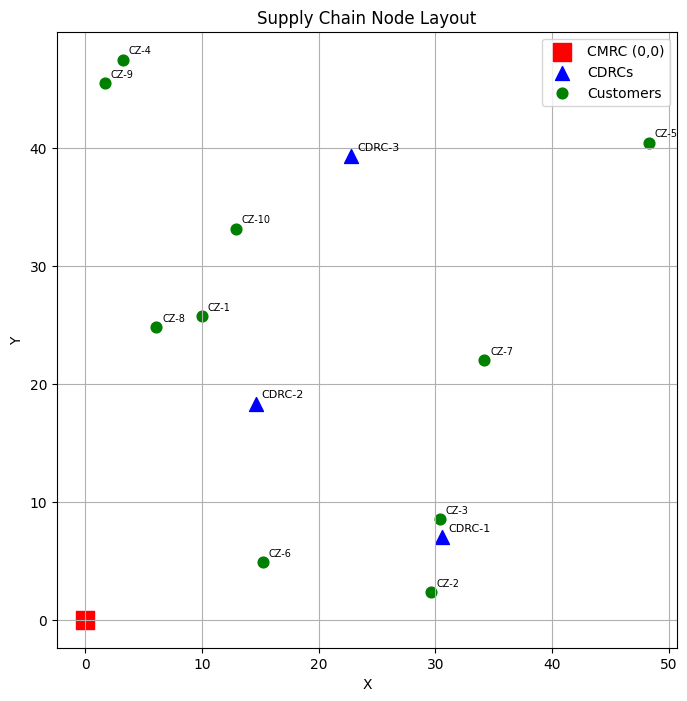

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(42)

# CMRC: Central Manufacturing & Repair Center
CMRC = np.array([[0, 0]])

# CDRC Coordinates
CDRC_coords = np.array([
    [30.59264474, 6.97469303],
    [14.60723243, 18.31809216],
    [22.80349921, 39.25879807]
])

# Customer Zone Coordinates
Customer_coords = np.array([
    [9.983689, 25.71172],
    [29.62073, 2.322521],
    [30.37724, 8.526206],
    [3.25258, 47.44428],
    [48.2816, 40.41987],
    [15.23069, 4.883606],
    [34.21165, 22.00762],
    [6.101912, 24.75885],
    [1.719426, 45.46602],
    [12.939, 33.12611]
])

dist_CMRC_to_CDRC = cdist(CMRC, CDRC_coords)[0]
dist_CDRC_to_Customers = cdist(CDRC_coords, Customer_coords)
dist_Customers_to_CDRC = cdist(Customer_coords, CDRC_coords)
dist_CDRC_to_CMRC = cdist(CDRC_coords, CMRC)[..., 0]

# Plot network
def plot_network():
    plt.figure(figsize=(8, 8))
    plt.scatter(*CMRC[0], color='red', label='CMRC (0,0)', s=150, marker='s')
    plt.scatter(CDRC_coords[:, 0], CDRC_coords[:, 1], c='blue', label='CDRCs', s=100, marker='^')
    plt.scatter(Customer_coords[:, 0], Customer_coords[:, 1], c='green', label='Customers', s=60)
    for i, (x, y) in enumerate(CDRC_coords):
        plt.text(x + 0.5, y + 0.5, f"CDRC-{i+1}", fontsize=8)
    for i, (x, y) in enumerate(Customer_coords):
        plt.text(x + 0.5, y + 0.5, f"CZ-{i+1}", fontsize=7)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.title("Supply Chain Node Layout")
    plt.legend()
    plt.show()

plot_network()


#Phase 2

In [ ]:
n_cdrc = CDRC_coords.shape[0]
n_customers = Customer_coords.shape[0]
n_products = 2
T = 240  # working days per year

# Demand: (customers × products)
demand = np.random.uniform(20, 30, (n_customers, n_products))

# Return rates
return_rate = np.random.uniform(0.3, 0.6, n_products)
fraction_defective = 0.3
fraction_non_defective = 0.7

# Fixed cost per CDRC
fixed_cost_cdrc = np.random.uniform(1000, 1500, n_cdrc)

# Administrative cost per unit
admin_cost = np.random.uniform(5, 10, (n_cdrc, n_products))

# Forward shipment costs (CMRC → CDRC) per km × 650
shipment_CMRC_to_CDRC = np.tile(650 * dist_CMRC_to_CDRC[:, None], (1, n_products))

# CDRC -> Customer (per km × 102)
shipment_CDRC_to_Customer = 102 * dist_CDRC_to_Customers[:, :, None]

# Holding cost
holding_cost = np.random.uniform(1, 3, (n_cdrc, n_products))

# Repair cost per product
recovery_cost = np.random.uniform(5, 10, n_products)

# Reverse shipment: CDRC → CMRC (per km × 102)
shipment_CDRC_to_CMRC = np.tile(102 * dist_CDRC_to_CMRC[:, None], (1, n_products))

# Emissions (5 kg CO₂ per km)
carbon_CMRC_to_CDRC = np.tile(5 * dist_CMRC_to_CDRC[:, None], (1, n_products))
carbon_CDRC_to_Customer = 5 * dist_CDRC_to_Customers[:, :, None]
carbon_Customer_to_CDRC = 5 * dist_Customers_to_CDRC
carbon_CDRC_to_CMRC = np.tile(5 * dist_CDRC_to_CMRC[:, None], (1, n_products))

params = {
    "n_customers": n_customers,
    "n_cdrc": n_cdrc,
    "n_products": n_products,
    "T": T,
    "demand": demand,
    "return_rate": return_rate,
    "fraction_defective": fraction_defective,
    "fraction_non_defective": fraction_non_defective,
    "fixed_cost_cdrc": fixed_cost_cdrc,
    "admin_cost": admin_cost,
    "shipment_CMRC_to_CDRC": shipment_CMRC_to_CDRC,
    "shipment_CDRC_to_Customer": shipment_CDRC_to_Customer,
    "shipment_CDRC_to_CMRC": shipment_CDRC_to_CMRC,
    "holding_cost": holding_cost,
    "recovery_cost": recovery_cost,
    "carbon_CMRC_to_CDRC": carbon_CMRC_to_CDRC,
    "carbon_CDRC_to_Customer": carbon_CDRC_to_Customer,
    "carbon_Customer_to_CDRC": carbon_Customer_to_CDRC,
    "carbon_CDRC_to_CMRC": carbon_CDRC_to_CMRC
}

print("✅ Phase 2 complete.")
print("Sample Demand:\n", demand[:3])
print("Return Rates:", return_rate)
print("Fixed Costs:", fixed_cost_cdrc)


✅ Phase 2 complete.
Sample Demand:
 [[23.74540119 29.50714306]
 [27.31993942 25.98658484]
 [21.5601864  21.5599452 ]]
Return Rates: [0.48355587 0.34184816]
Fixed Costs: [1146.07232427 1183.18092165 1228.03499211]


#Phase 3

In [ ]:
import numpy as np

def compute_total_cost(assignments, order_qty, params):
    n_customers = params["n_customers"]
    n_cdrc = params["n_cdrc"]
    n_products = params["n_products"]

    T = params["T"]
    demand = params["demand"]
    q = params["return_rate"]
    gamma = params["fraction_defective"]

    a = params["fixed_cost_cdrc"]
    b = params["admin_cost"]
    c = params["shipment_CMRC_to_CDRC"]
    d = params["shipment_CDRC_to_Customer"]
    r = params["shipment_CDRC_to_CMRC"]
    h = params["holding_cost"]
    repair_cost = params["recovery_cost"]

    Y = np.zeros(n_cdrc)
    total_cost = 0

    for i in range(n_customers):
        for p in range(n_products):
            assigned_r = assignments[i, p]
            Y[assigned_r] = 1
            dem = demand[i, p]

            # Forward shipping cost
            total_cost += T * dem * d[assigned_r, i, 0]

            # Return & repair cost
            total_cost += T * dem * q[p] * (
                gamma * repair_cost[p] +
                r[assigned_r, p]
            )

    # Setup, admin, inventory costs
    for r_idx in range(n_cdrc):
        if Y[r_idx]:
            total_cost += a[r_idx]
            for p in range(n_products):
                total_cost += (
                    b[r_idx, p] +
                    c[r_idx, p] +
                    h[r_idx, p] * order_qty[r_idx, p] / 2
                )

    return total_cost

In [ ]:
def compute_total_emissions(assignments, params):
    n_customers = params["n_customers"]
    n_cdrc = params["n_cdrc"]
    n_products = params["n_products"]

    T = params["T"]
    demand = params["demand"]
    q = params["return_rate"]

    e1 = params["carbon_CMRC_to_CDRC"]
    e2 = params["carbon_CDRC_to_Customer"]
    e3 = params["carbon_Customer_to_CDRC"]
    e4 = params["carbon_CDRC_to_CMRC"]

    total_emissions = 0

    for i in range(n_customers):
        for p in range(n_products):
            r = assignments[i, p]
            total_emissions += T * demand[i, p] * (
                e1[r, p] +
                e2[r, i, 0] +
                q[p] * (e3[i, r] + e4[r, p])
            )

    return total_emissions

In [ ]:
# Assign everyone to CDRC 0 and random order quantities
dummy_assignments = np.zeros((n_customers, n_products), dtype=int)
dummy_order_qty = np.random.uniform(100, 200, (n_cdrc, n_products))

z1 = compute_total_cost(dummy_assignments, dummy_order_qty, params)
z2 = compute_total_emissions(dummy_assignments, params)

print("Z1 (Total Cost):", round(z1, 2))
print("Z2 (Total Emissions):", round(z2, 2))


Z1 (Total Cost): 470953831.82
Z2 (Total Emissions): 47919321.39


#Phase 4

In [ ]:
from pymoo.core.problem import ElementwiseProblem

class SupplyChainNSGA2Problem(ElementwiseProblem):
    def __init__(self, params):
        self.params = params
        self.n_customers = params["n_customers"]
        self.n_products = params["n_products"]
        self.n_cdrc = params["n_cdrc"]

        self.n_assign_vars = self.n_customers * self.n_products
        self.n_order_vars = self.n_cdrc * self.n_products
        n_var = self.n_assign_vars + self.n_order_vars

        xl = np.array([0] * self.n_assign_vars + [10.0] * self.n_order_vars)
        xu = np.array([self.n_cdrc - 1 + 0.9999] * self.n_assign_vars + [300.0] * self.n_order_vars)

        super().__init__(
            n_var=n_var,
            n_obj=2,
            n_constr=0,
            xl=xl,
            xu=xu,
            elementwise=True
        )

    def _evaluate(self, x, out, *args, **kwargs):
        assign_flat = x[:self.n_assign_vars]
        order_flat = x[self.n_assign_vars:]

        assign_flat = np.clip(np.floor(assign_flat), 0, self.n_cdrc - 1).astype(int)
        assignments = assign_flat.reshape((self.n_customers, self.n_products))
        order_qty = order_flat.reshape((self.n_cdrc, self.n_products))

        z1 = compute_total_cost(assignments, order_qty, self.params)
        z2 = compute_total_emissions(assignments, self.params)

        out["F"] = [z1, z2]

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination.default import DefaultMultiObjectiveTermination

# NSGA-II setup
algorithm = NSGA2(
    pop_size=150,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = DefaultMultiObjectiveTermination()


In [ ]:
from pymoo.optimize import minimize
import time
problem = SupplyChainNSGA2Problem(params)
start_time = time.time()
res = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    save_history=True,
    verbose=True
)
end_time = time.time()
elapsed_time = end_time - start_time
print("\n✅ Optimization Summary")
print(f"Total Generations Run: {len(res.history)}")
print(f"Computation Time: {elapsed_time:.2f} seconds")


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |      1 |             - |             -
     2 |      300 |      2 |  1.0000000000 |         ideal
     3 |      450 |      2 |  2.1066156479 |         ideal
     4 |      600 |      1 |  1.785421E+07 |         ideal
     5 |      750 |      1 |  8.572379E+06 |         ideal
     6 |      900 |      4 |  0.9571818406 |         ideal
     7 |     1050 |      2 |  1.9440320466 |         ideal
     8 |     1200 |      3 |  0.5712671859 |         ideal
     9 |     1350 |      6 |  0.2954374675 |         ideal
    10 |     1500 |      6 |  0.5732444274 |         ideal
    11 |     1650 |      6 |  0.0961608212 |         ideal
    12 |     1800 |     11 |  0.0696103101 |             f
    13 |     1950 |     12 |  0.0413681408 |             f
    14 |     2100 |     14 |  0.0058292623 |             f
    15 |     2250 |     14 |  0.0257129288 |         ideal
    16 |     2400 |     13 |  0.0040896167 |            

#Phase 5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_each_generation_separately(res):
    generations = len(res.history)

    for gen_idx in range(generations):
        F = res.history[gen_idx].opt.get("F")
        if F is None or len(F) < 2:
            continue

        Z1 = F[:, 0]
        Z2 = F[:, 1]
        sorted_idx = np.argsort(Z1)

        plt.figure(figsize=(8, 6))
        plt.plot(Z1[sorted_idx], Z2[sorted_idx], marker='o', linestyle='-', color='tab:blue')
        plt.xlabel("Z1: Total Cost")
        plt.ylabel("Z2: Carbon Emissions")
        plt.title(f"Pareto Front - Generation {gen_idx}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


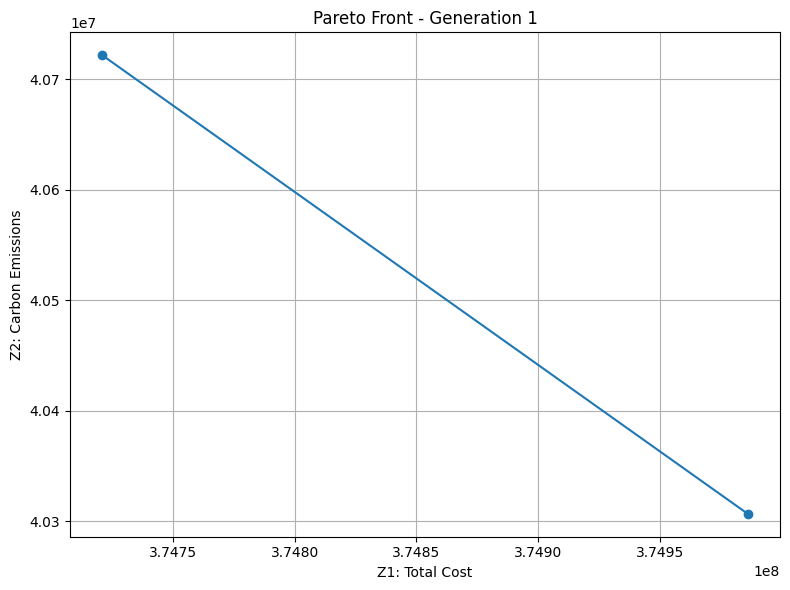

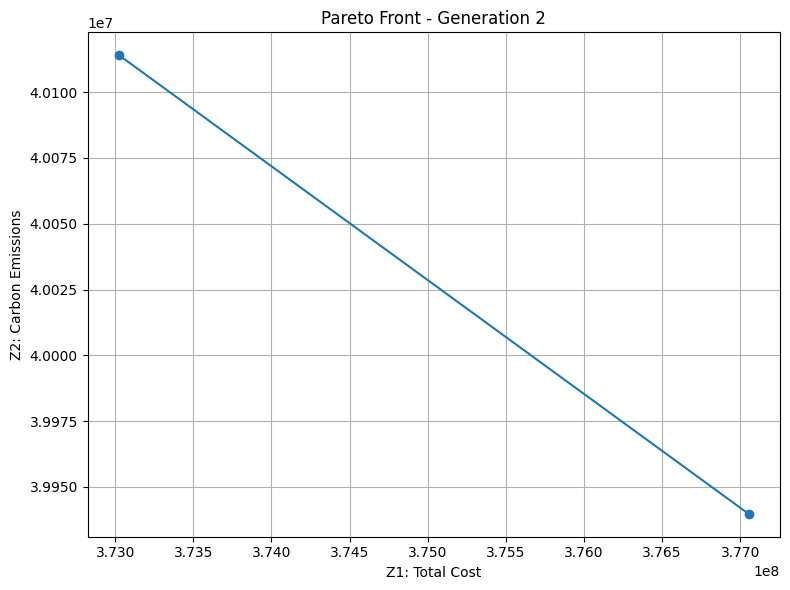

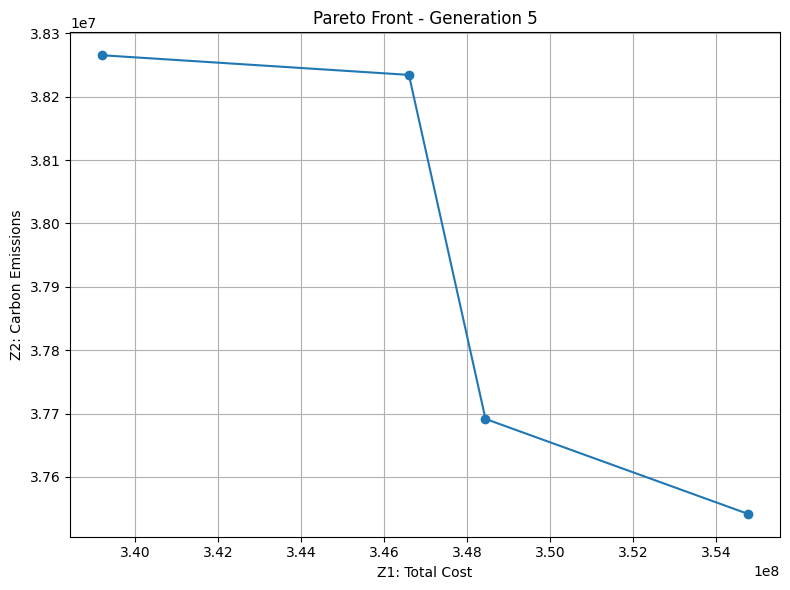

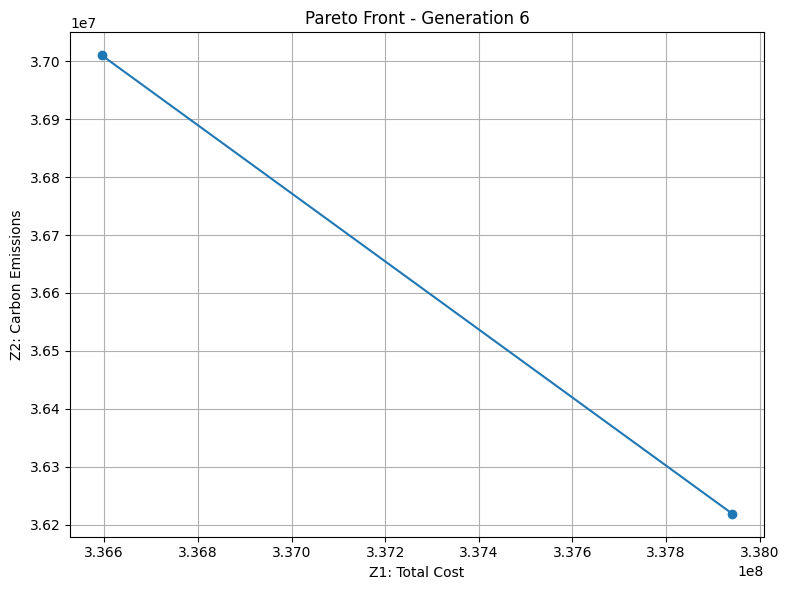

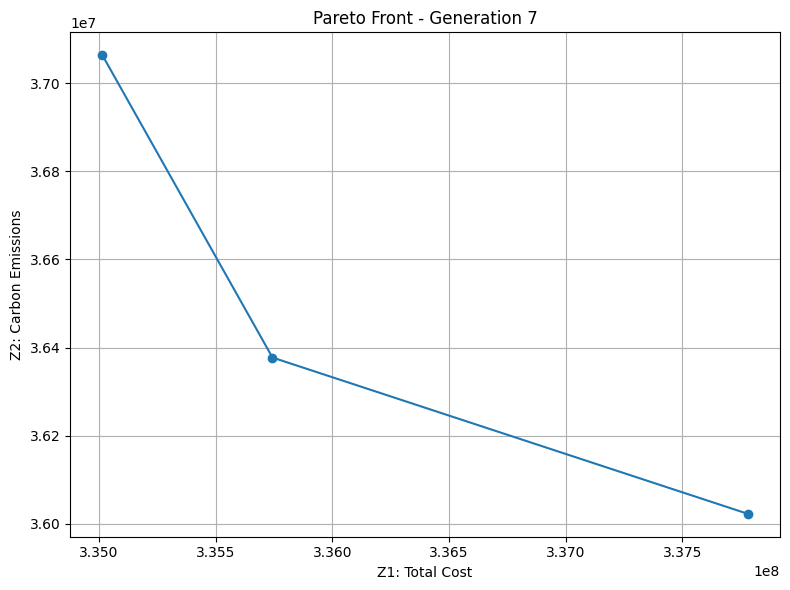

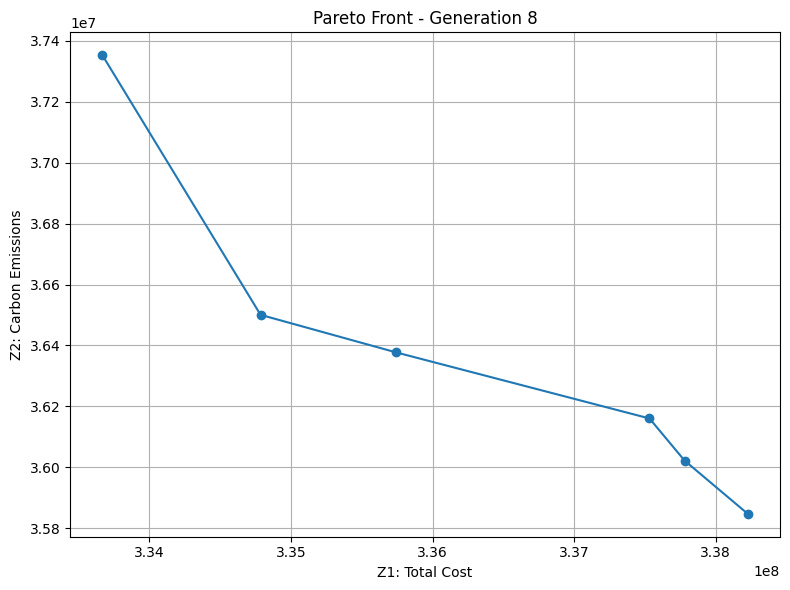

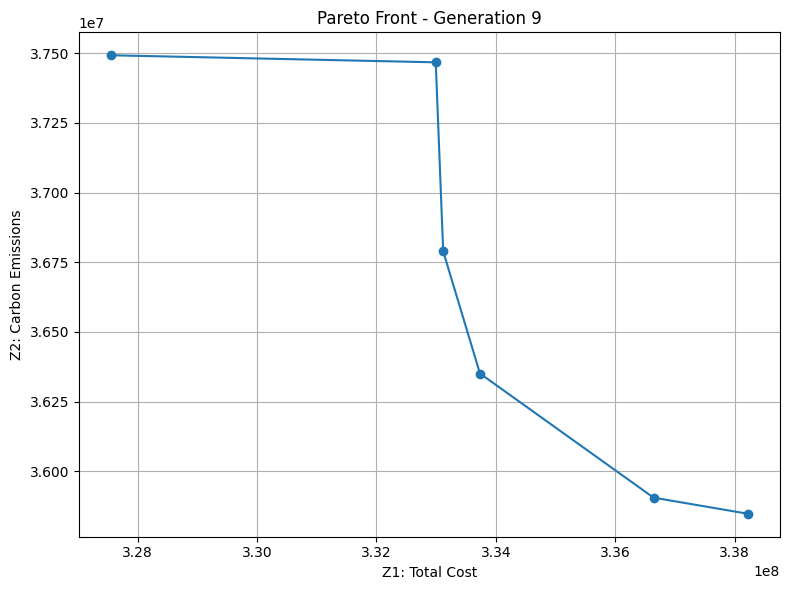

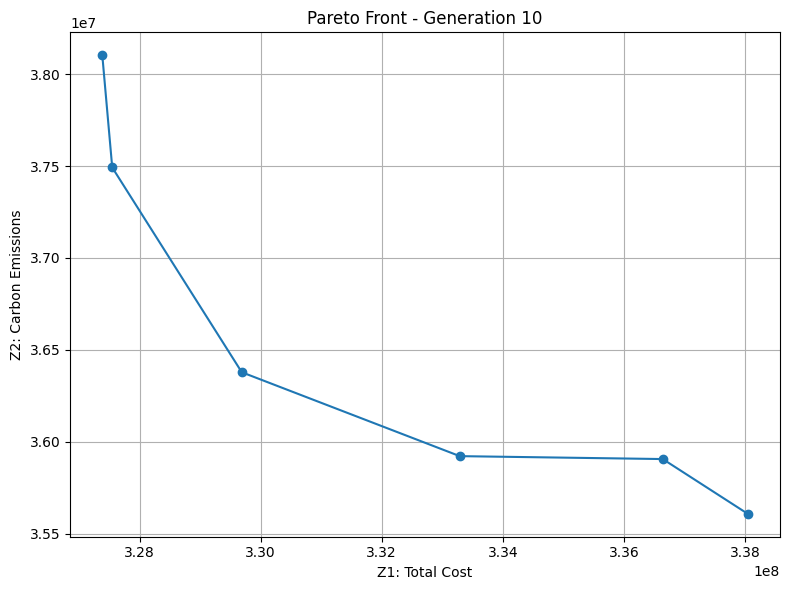

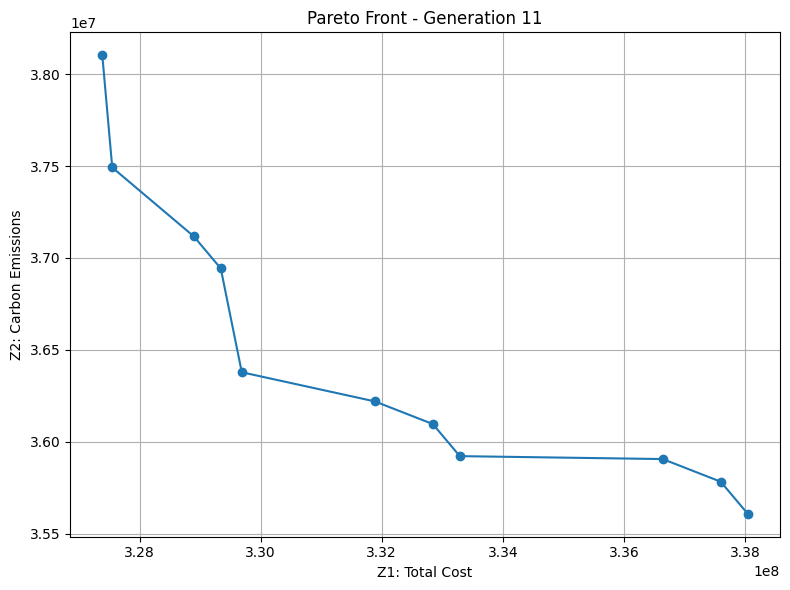

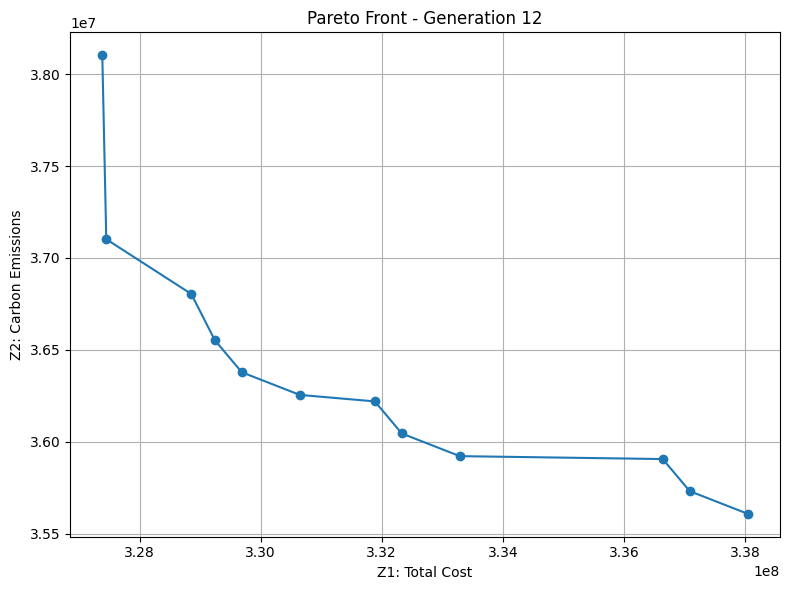

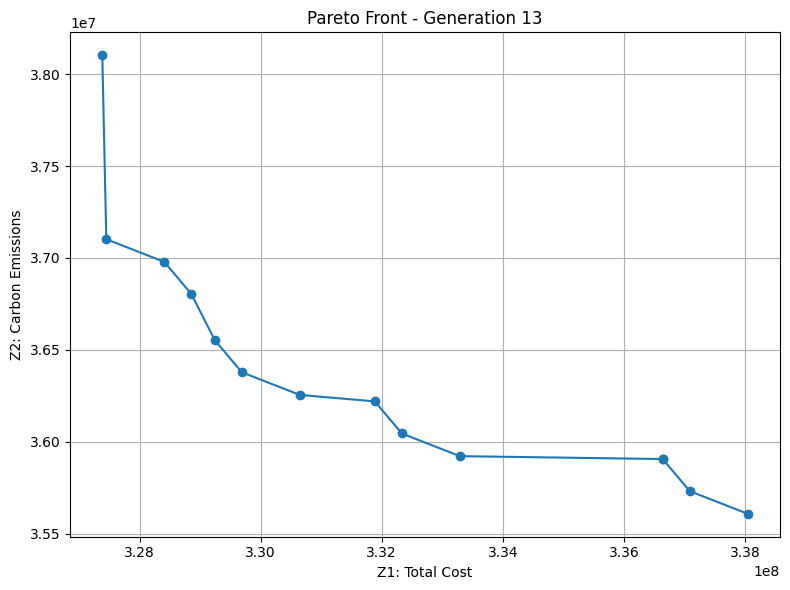

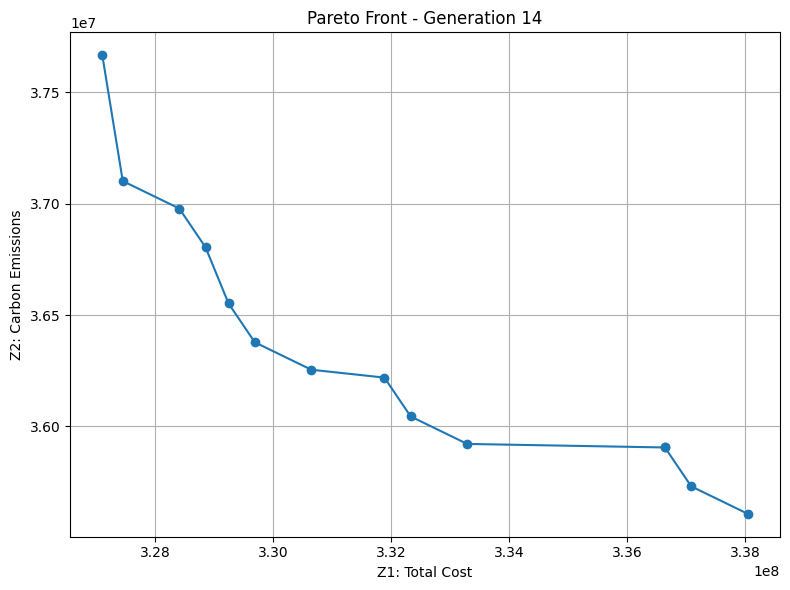

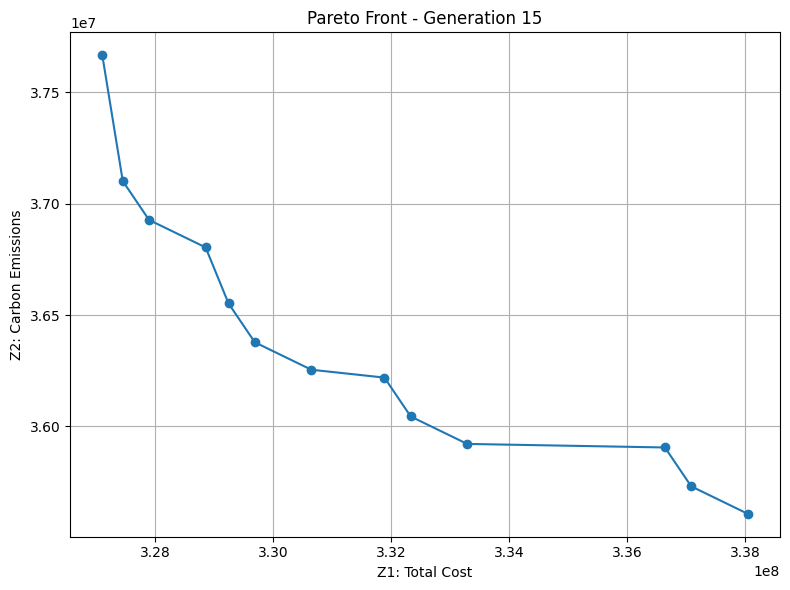

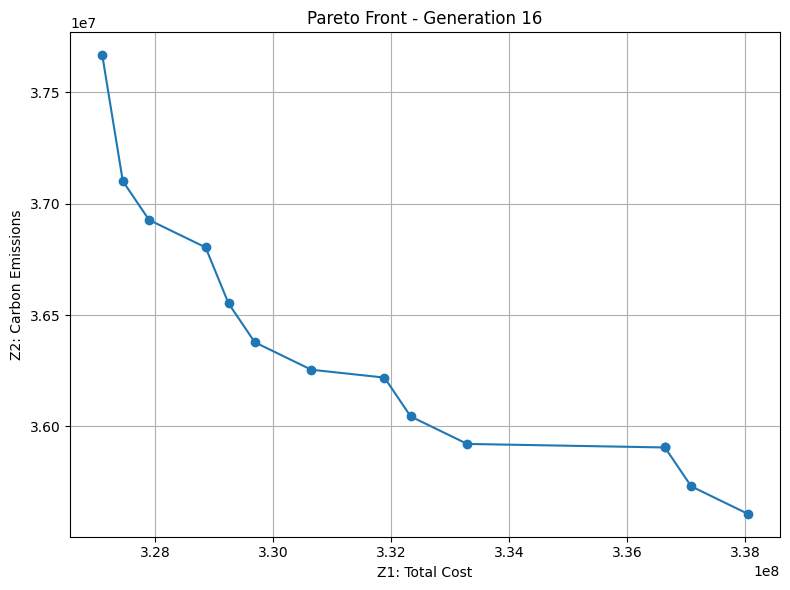

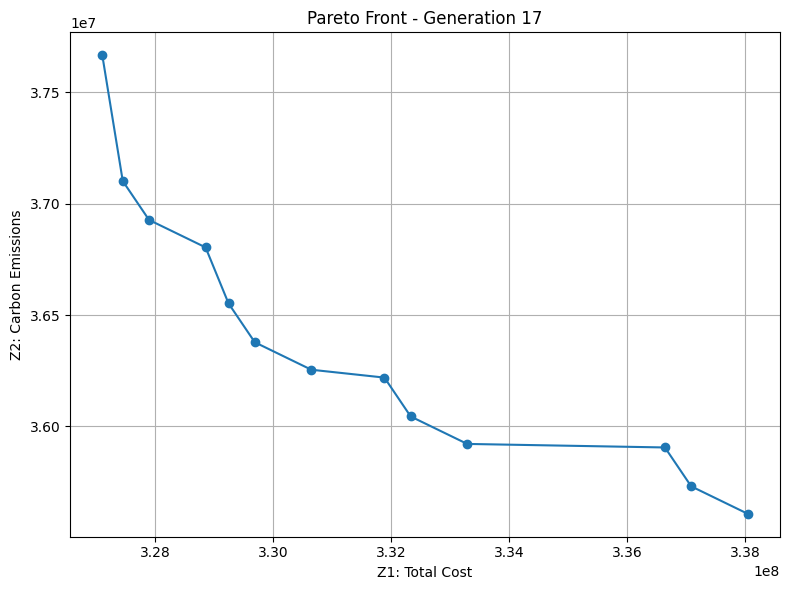

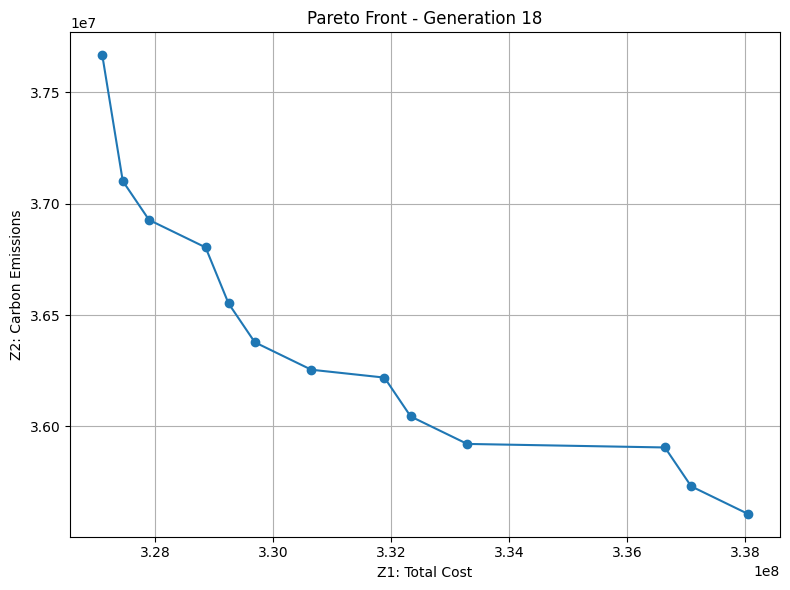

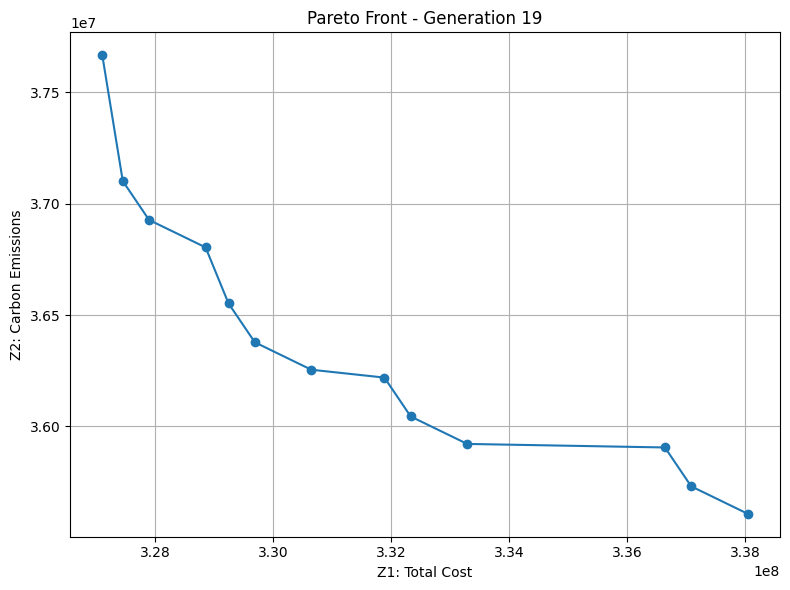

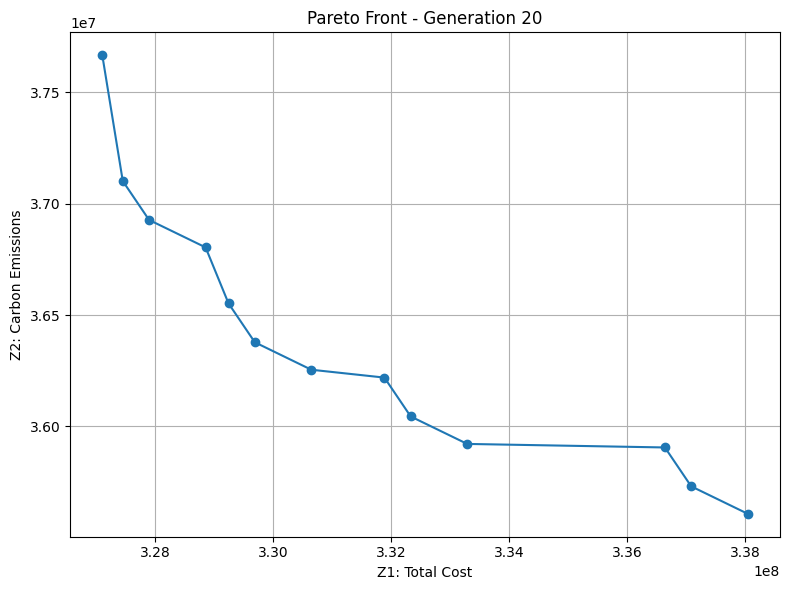

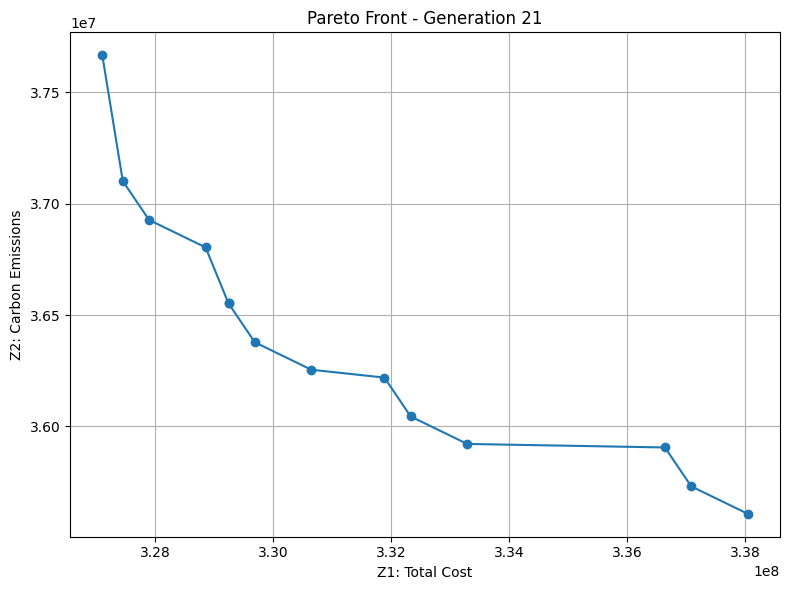

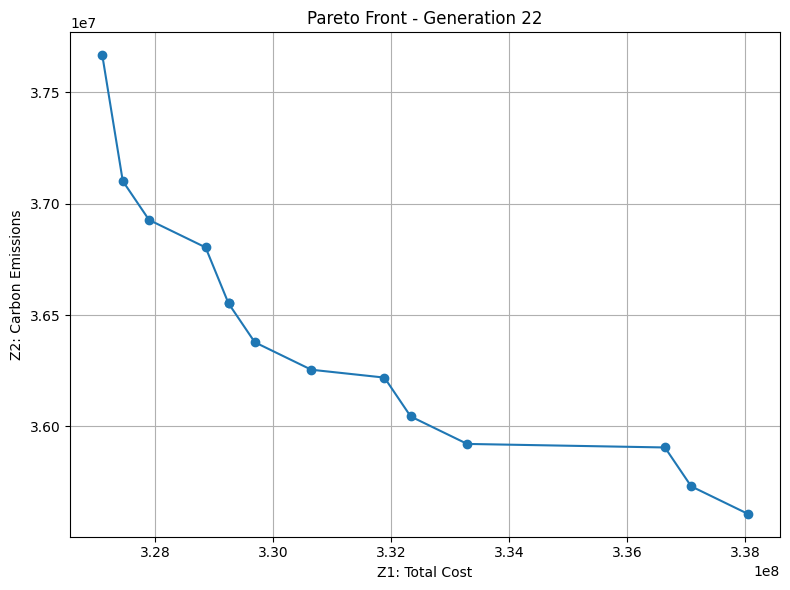

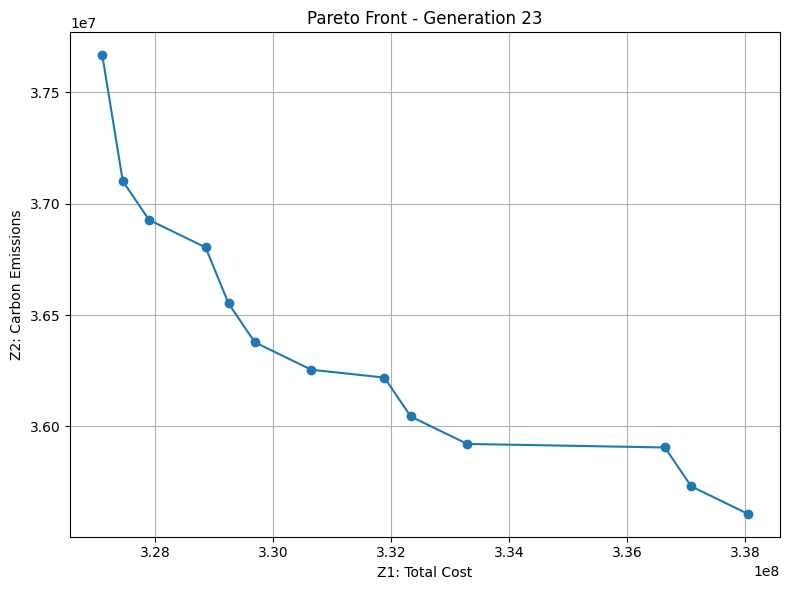

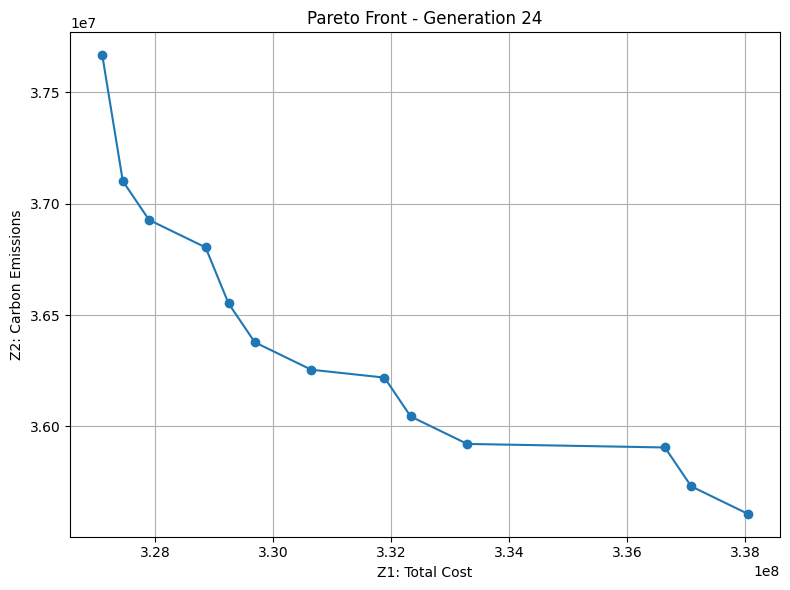

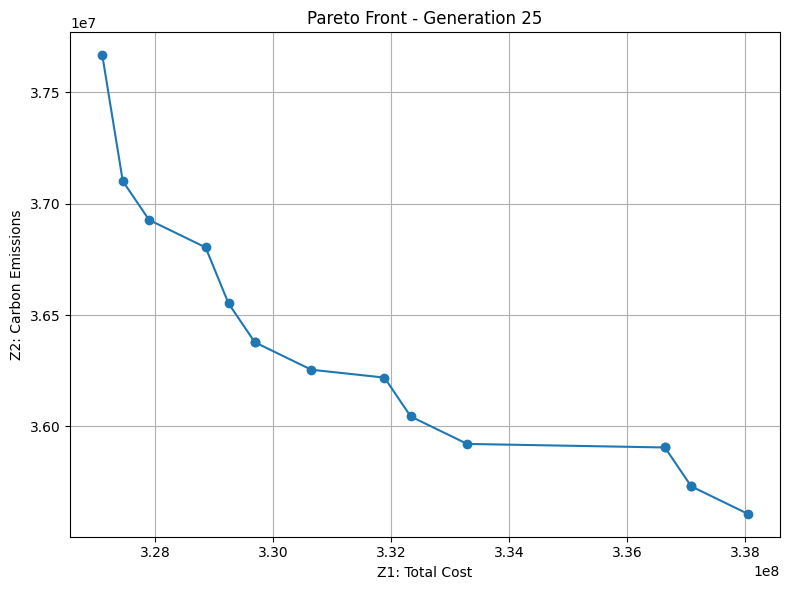

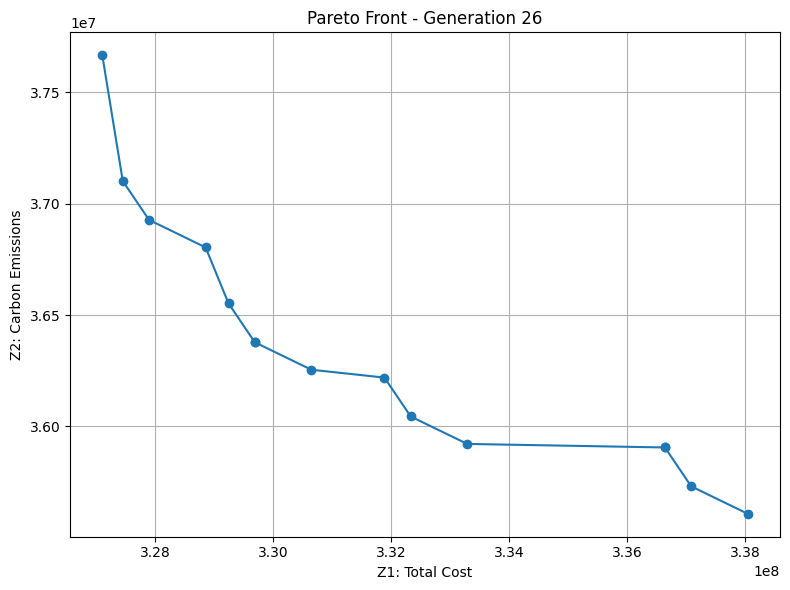

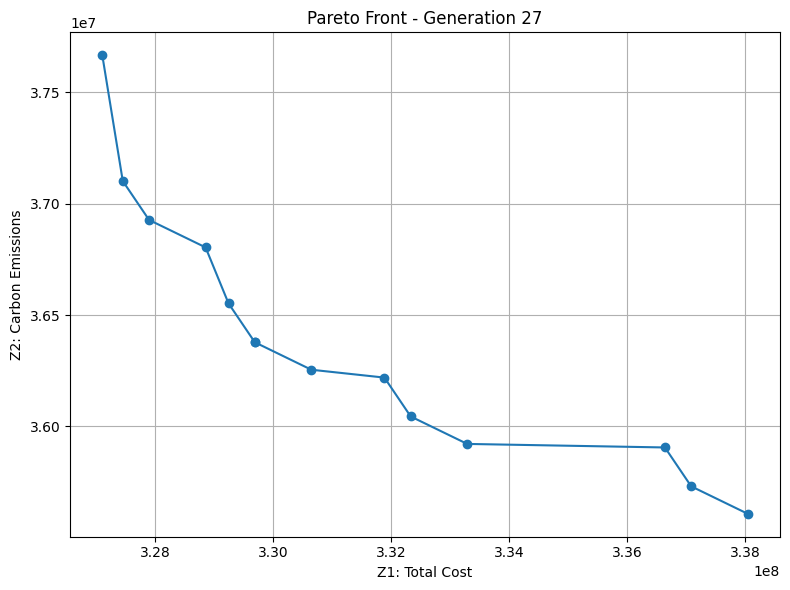

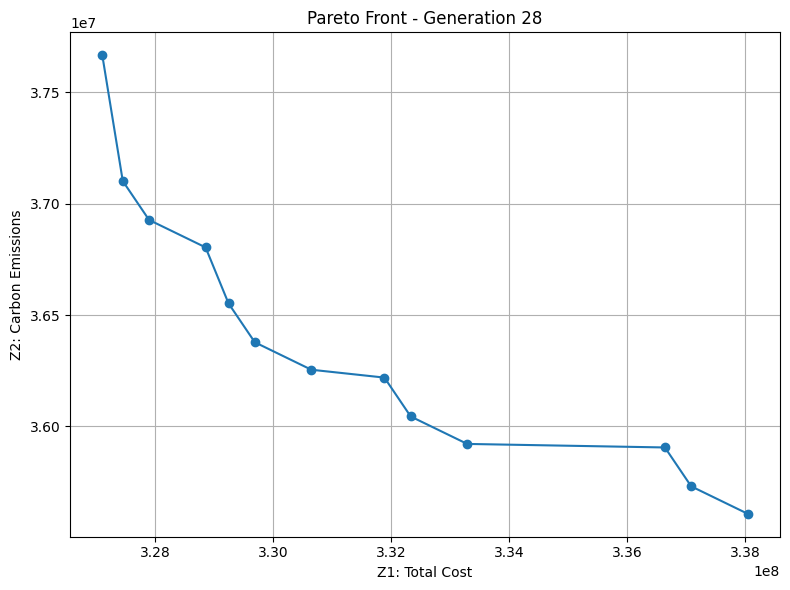

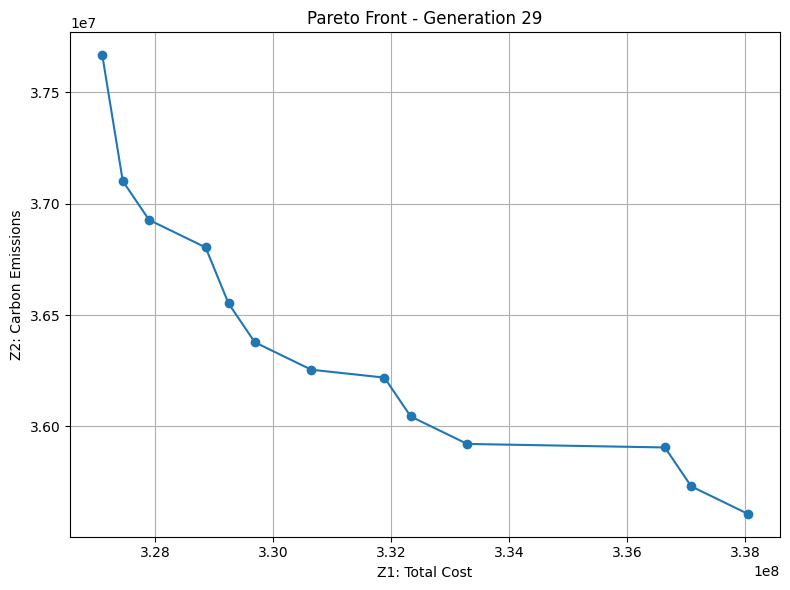

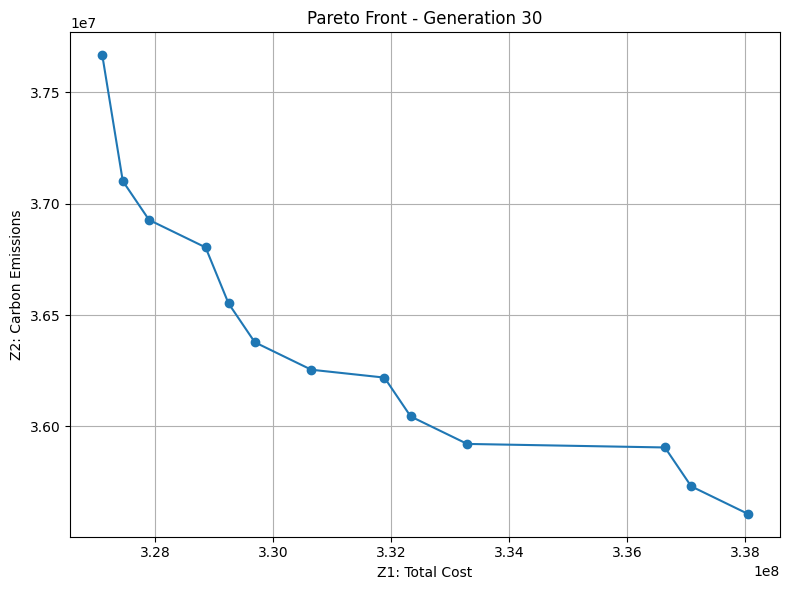

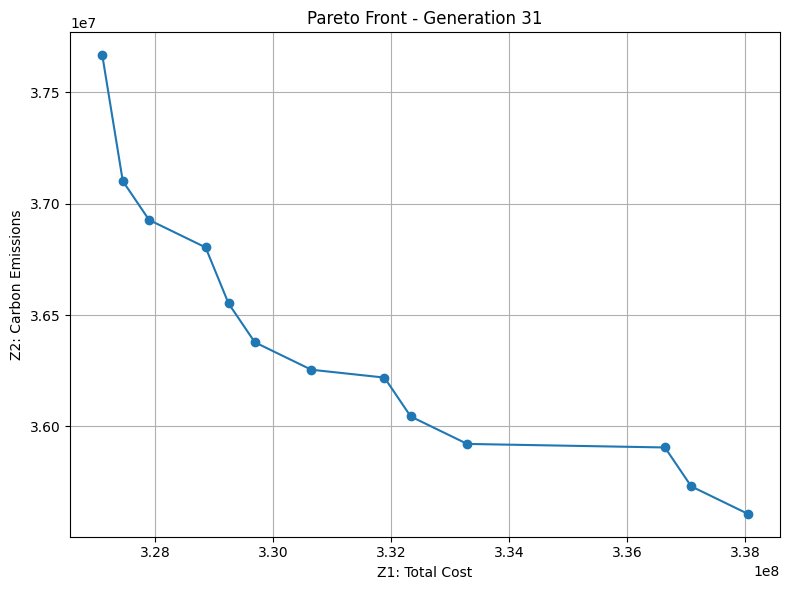

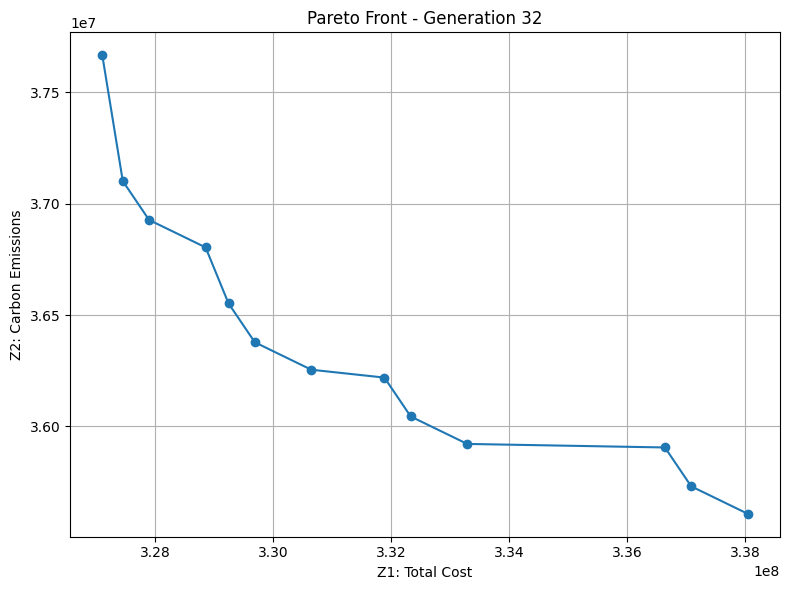

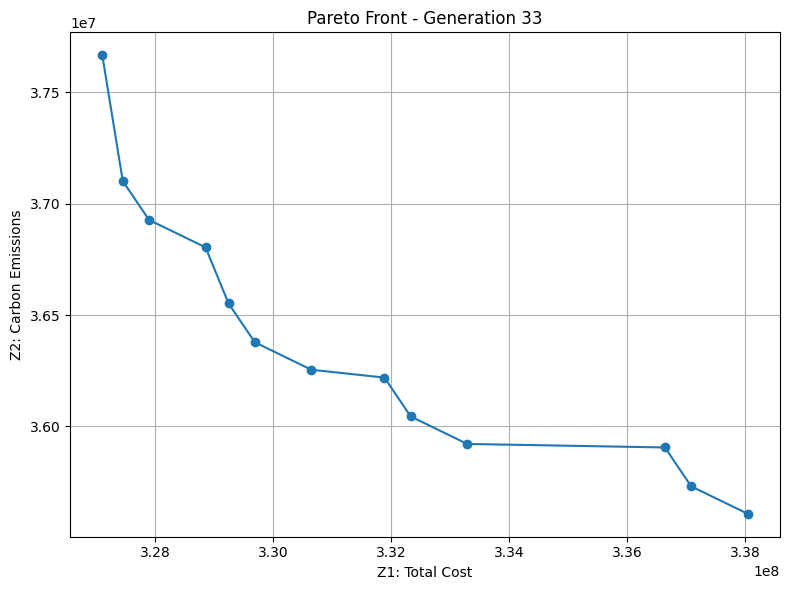

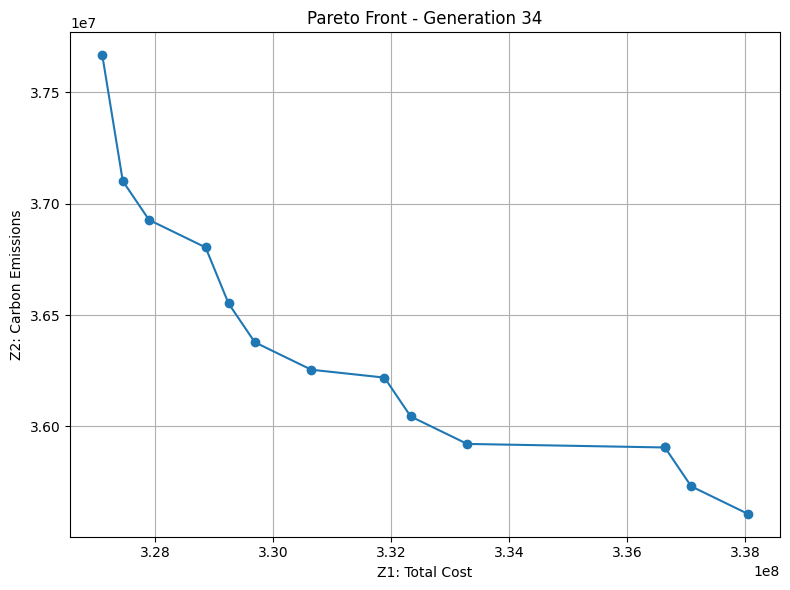

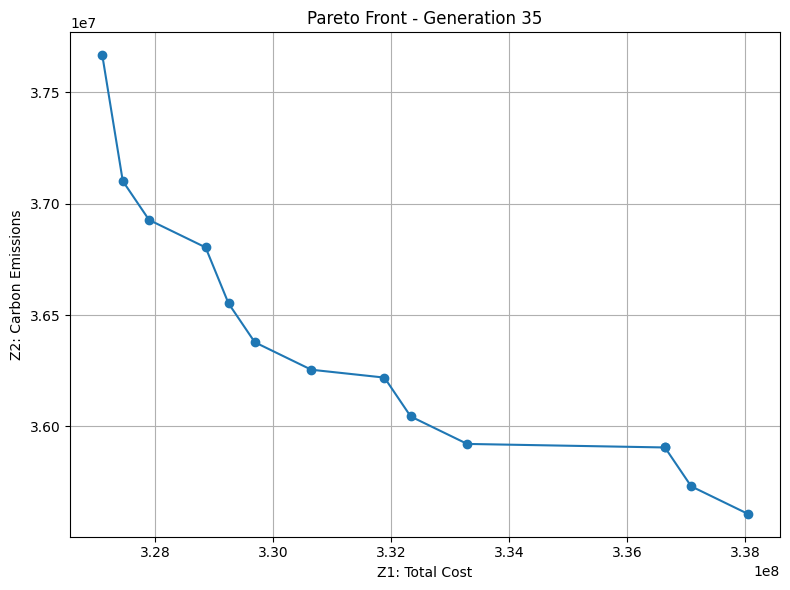

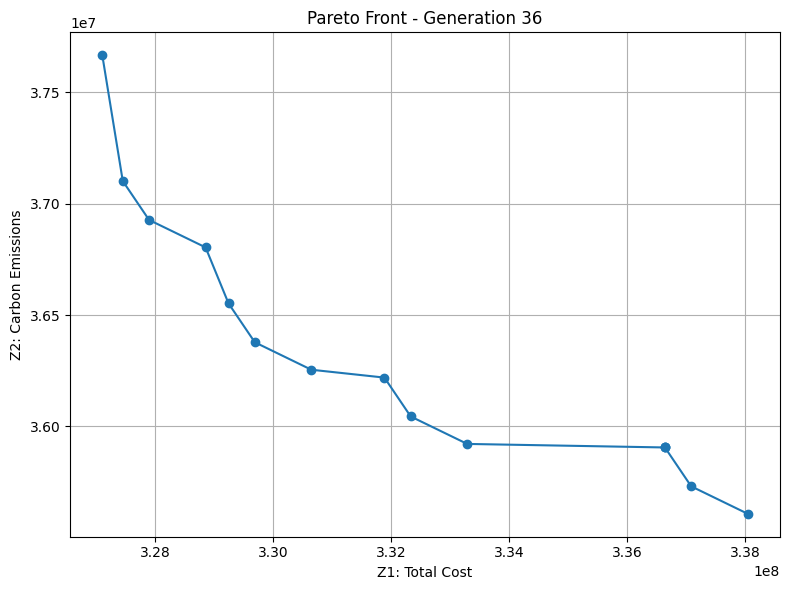

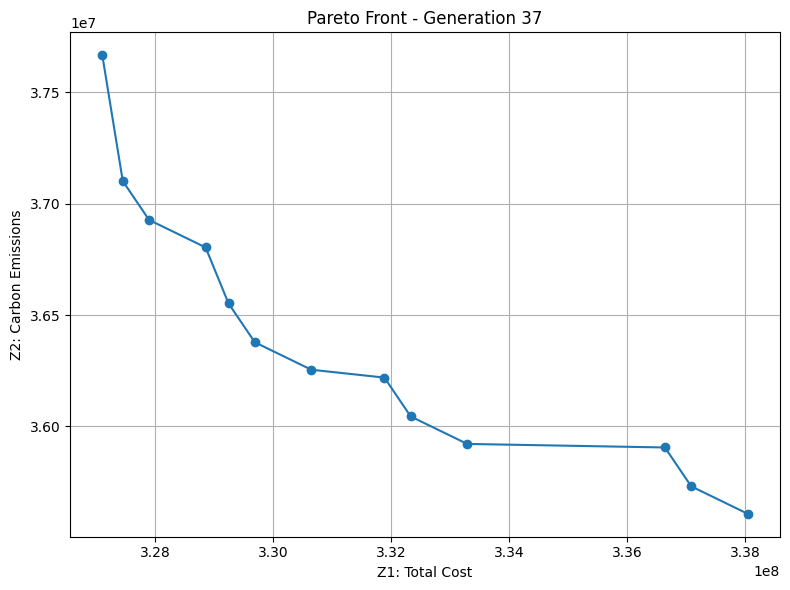

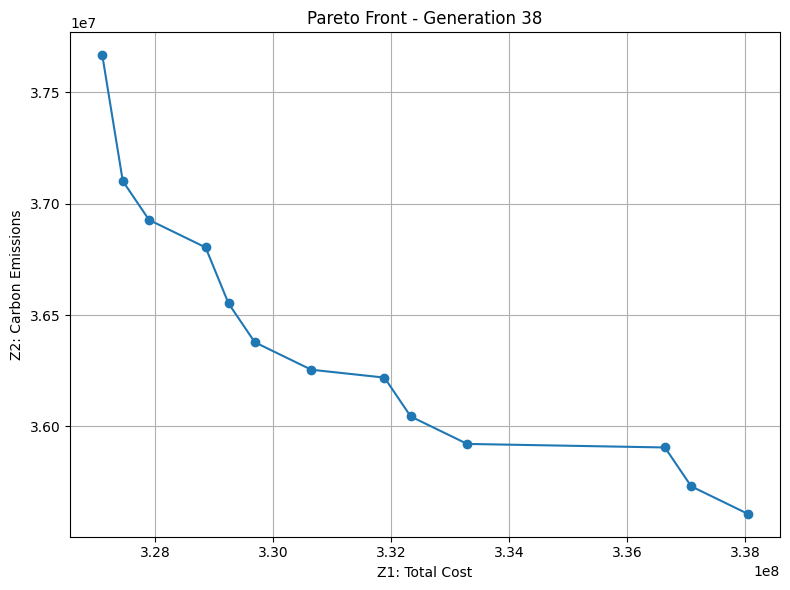

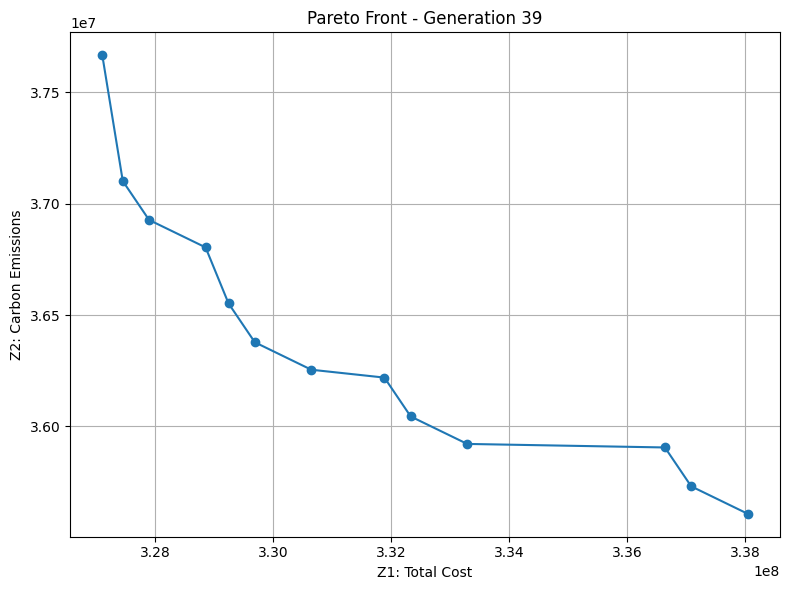

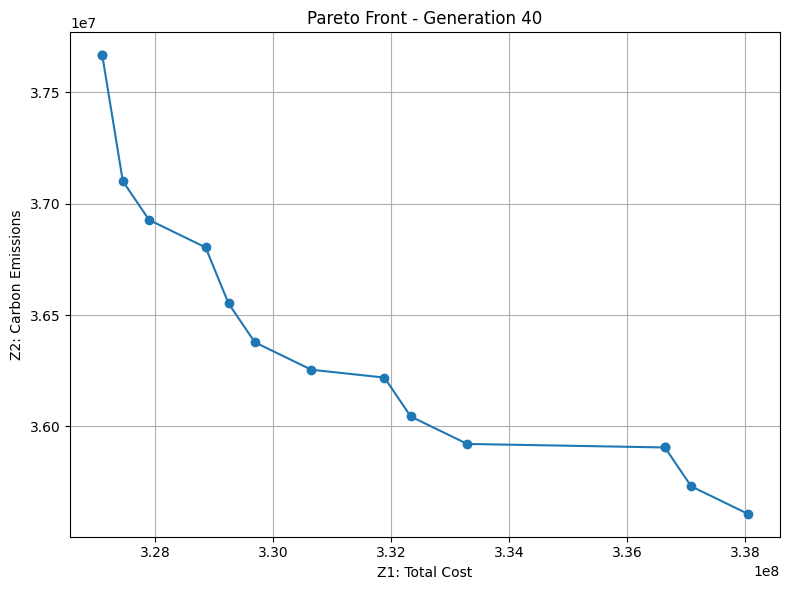

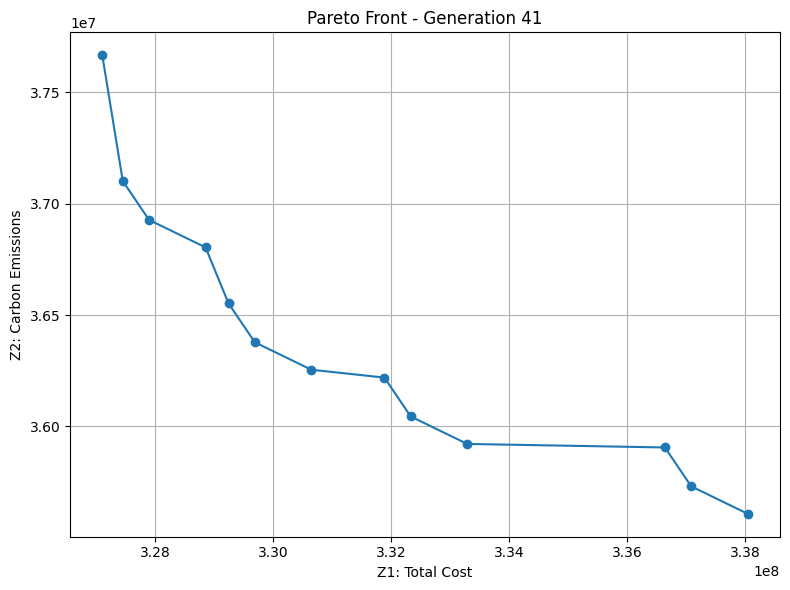

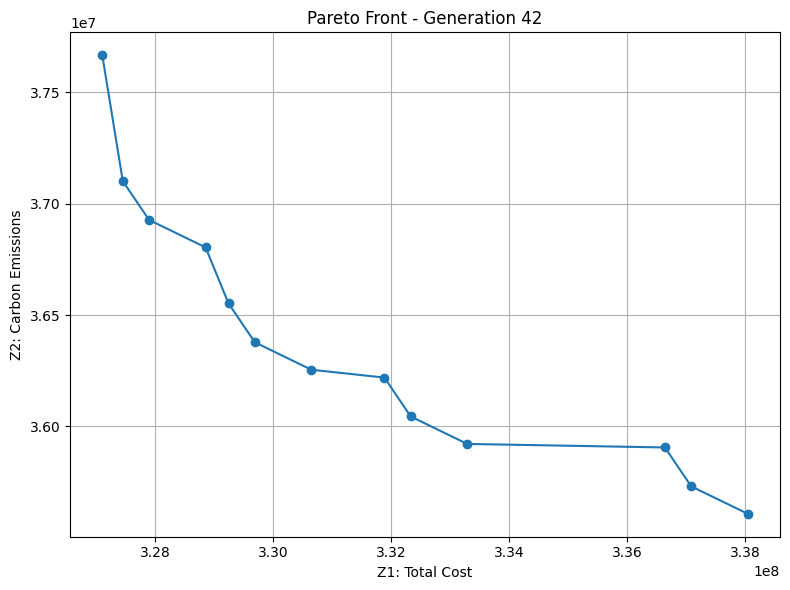

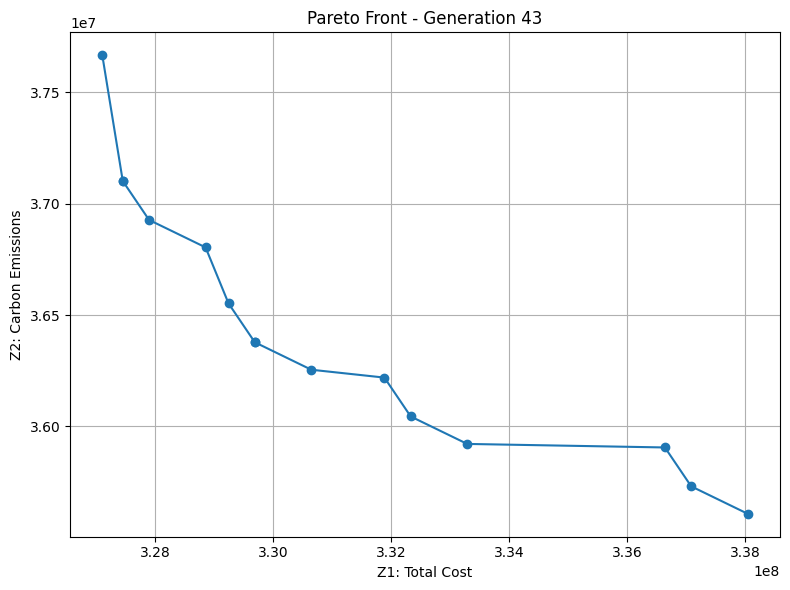

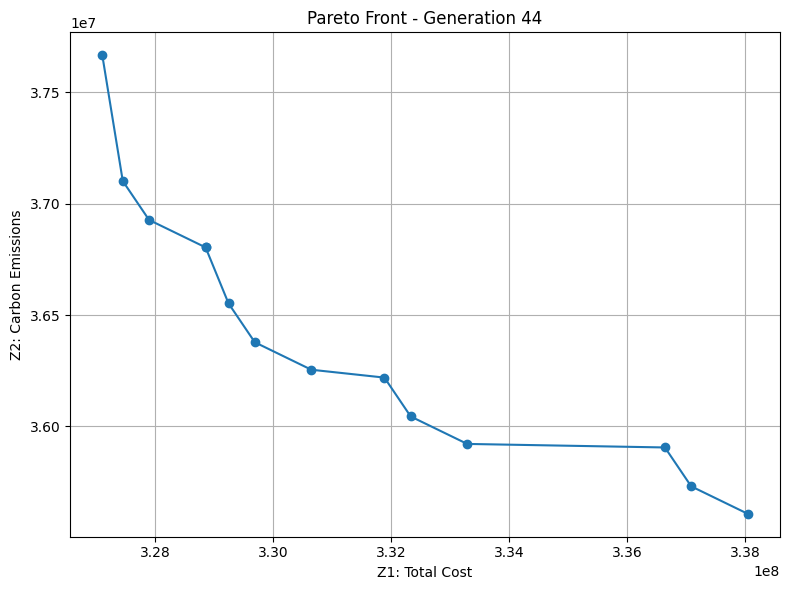

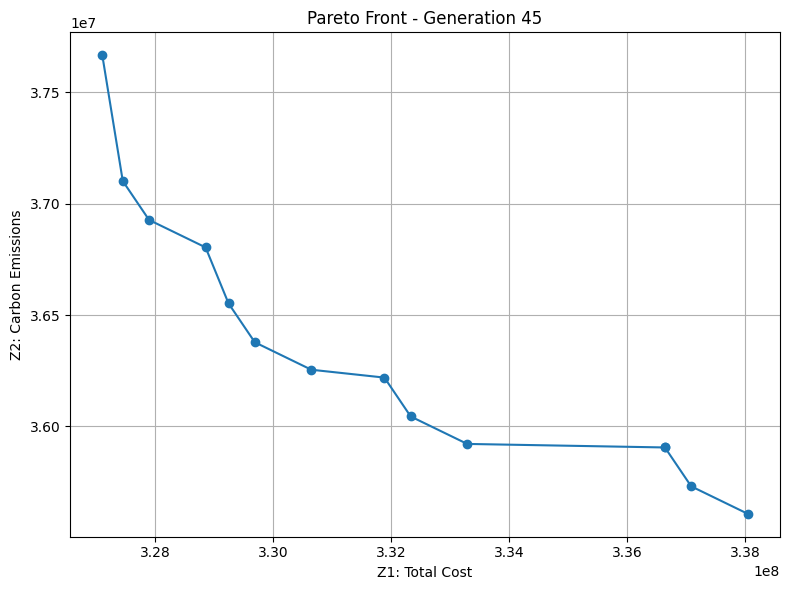

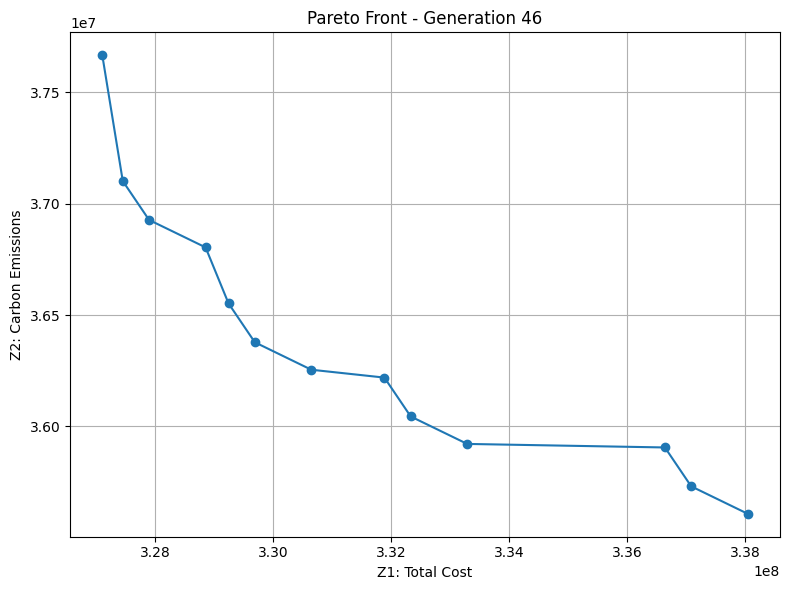

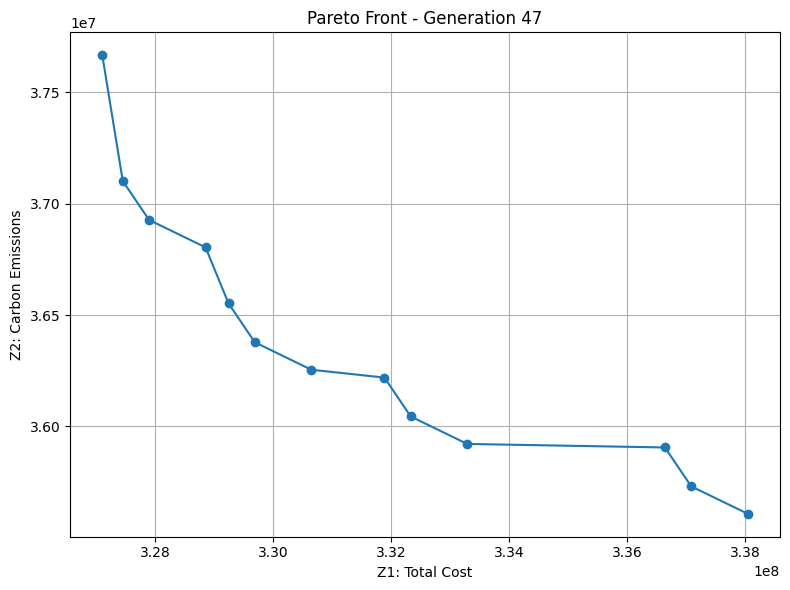

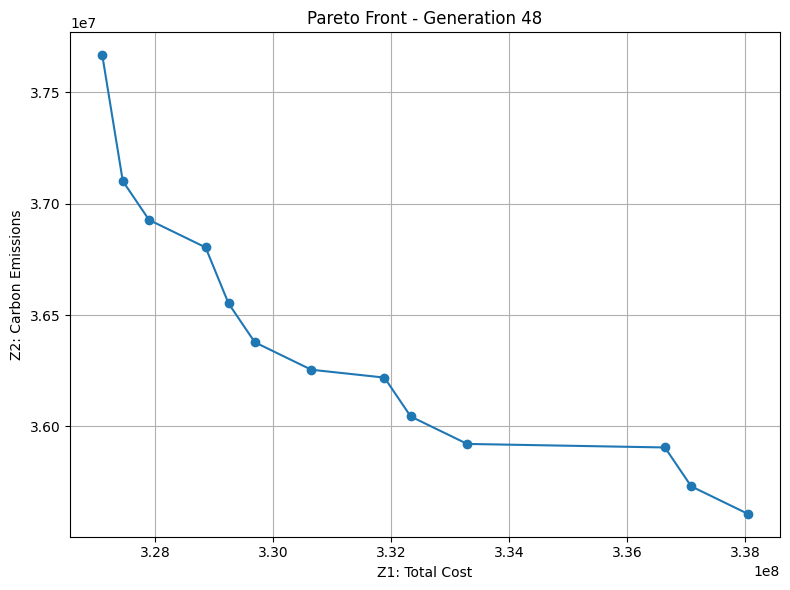

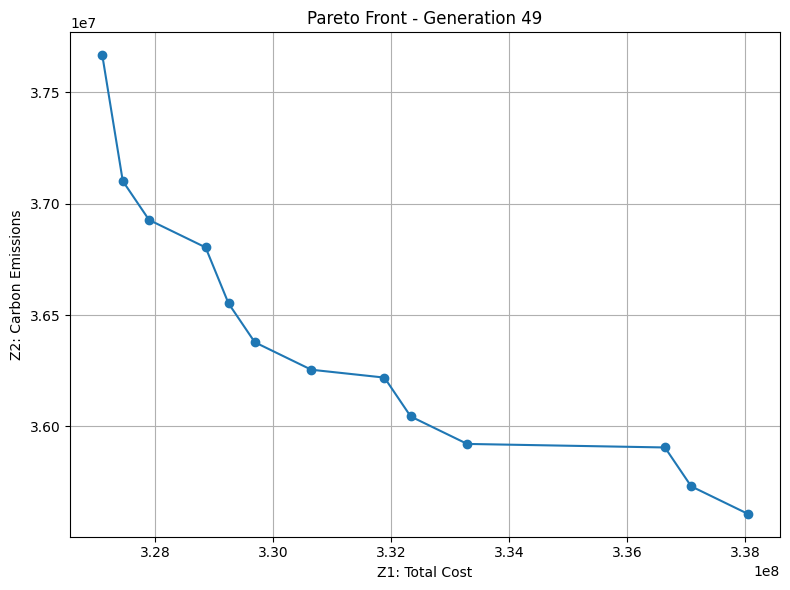

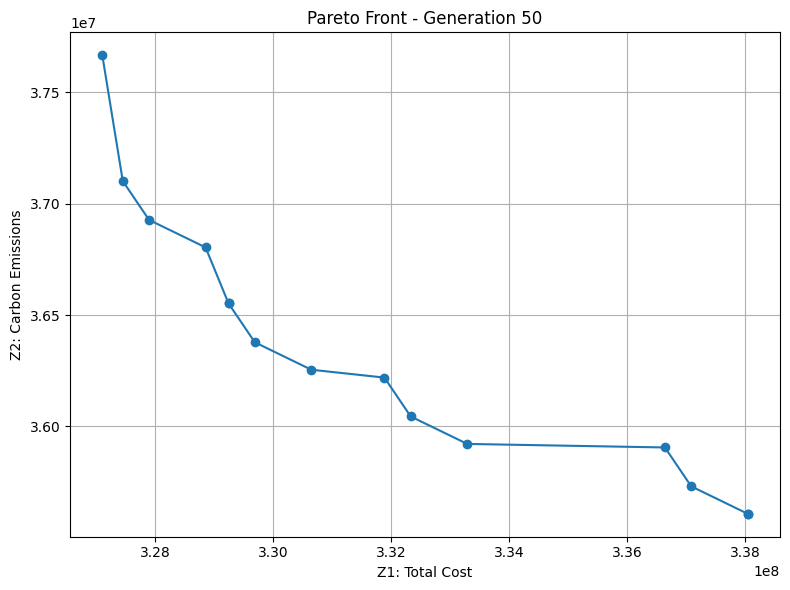

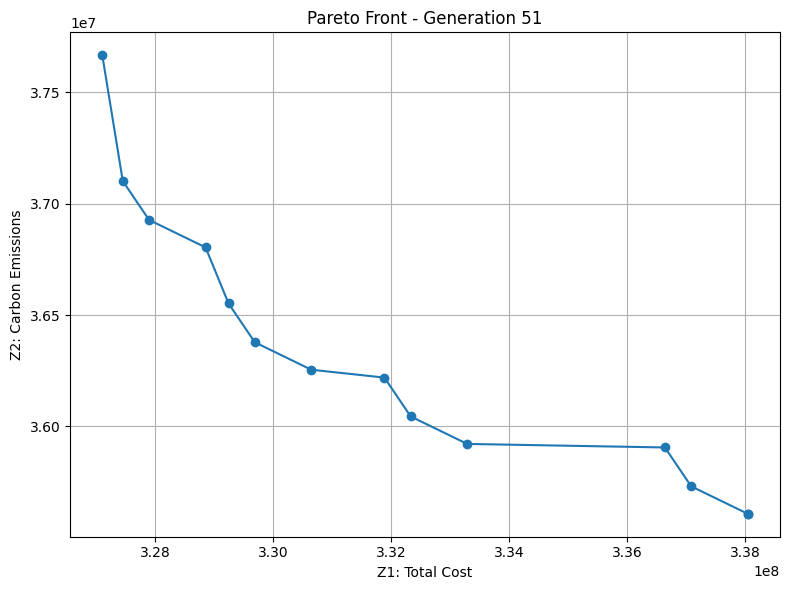

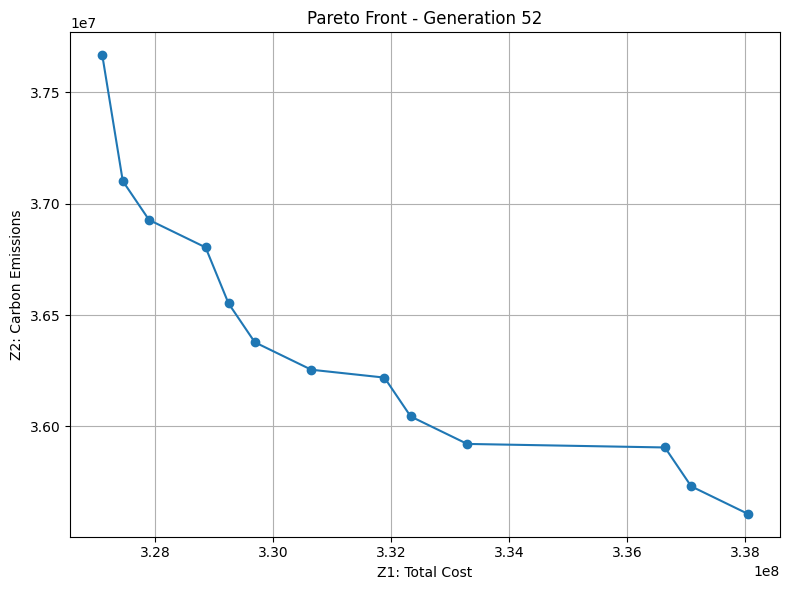

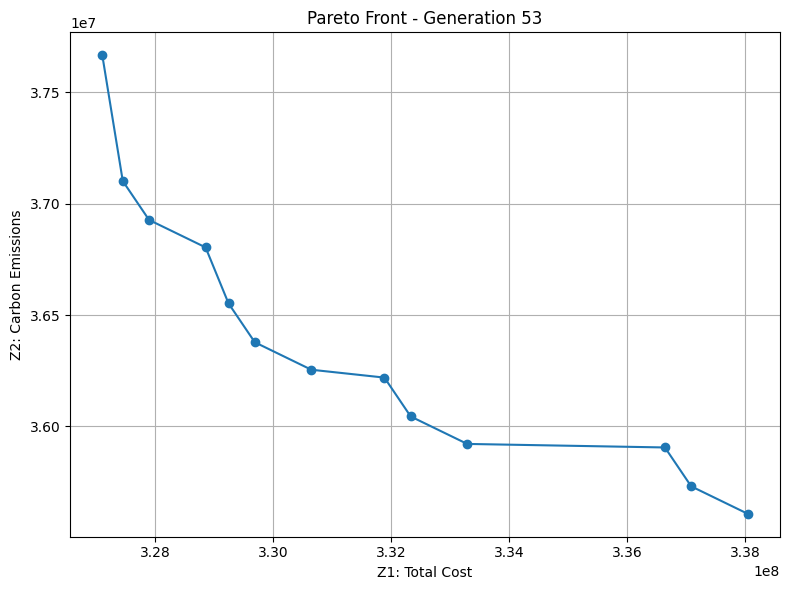

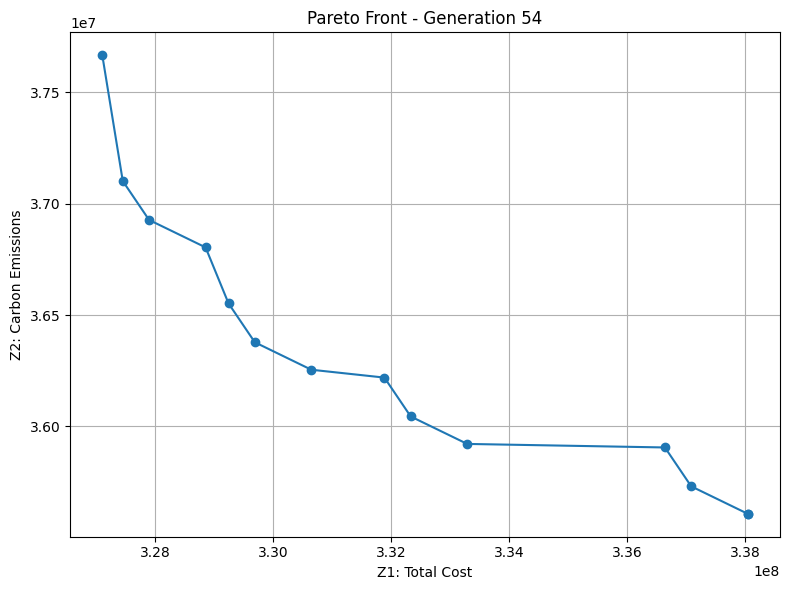

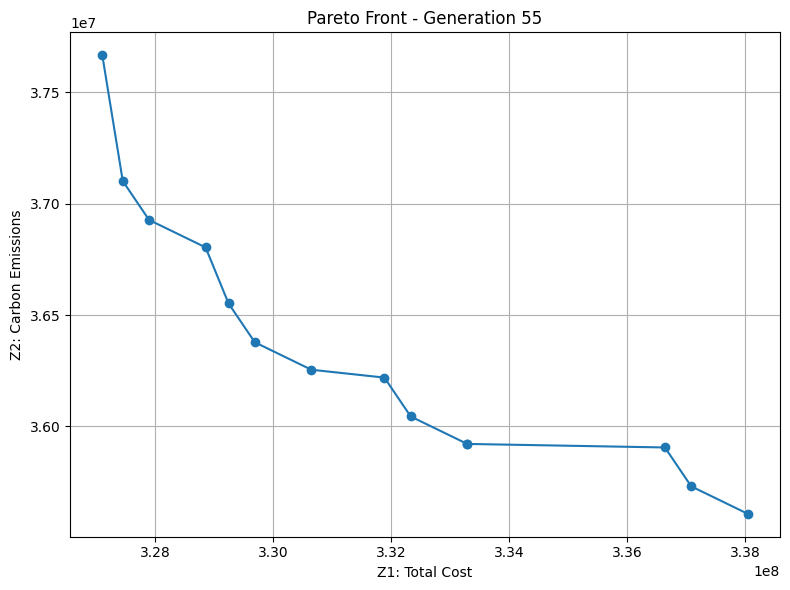

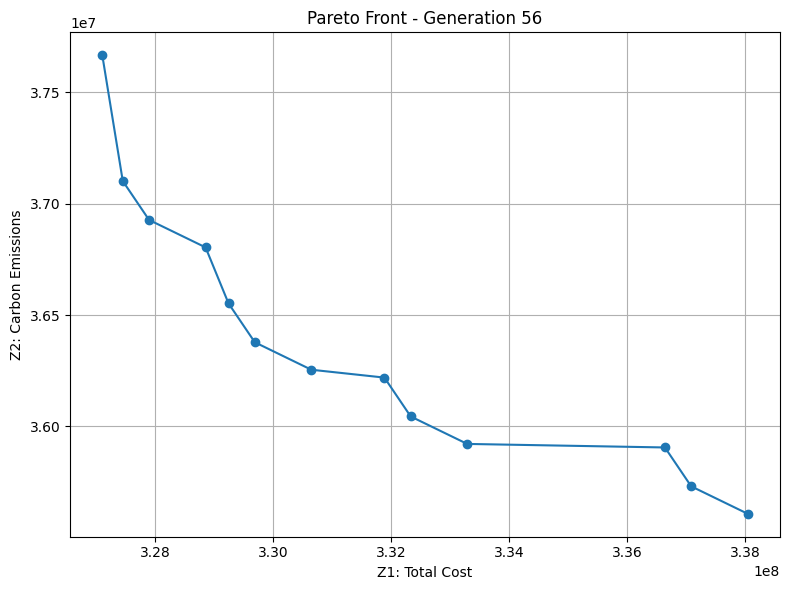

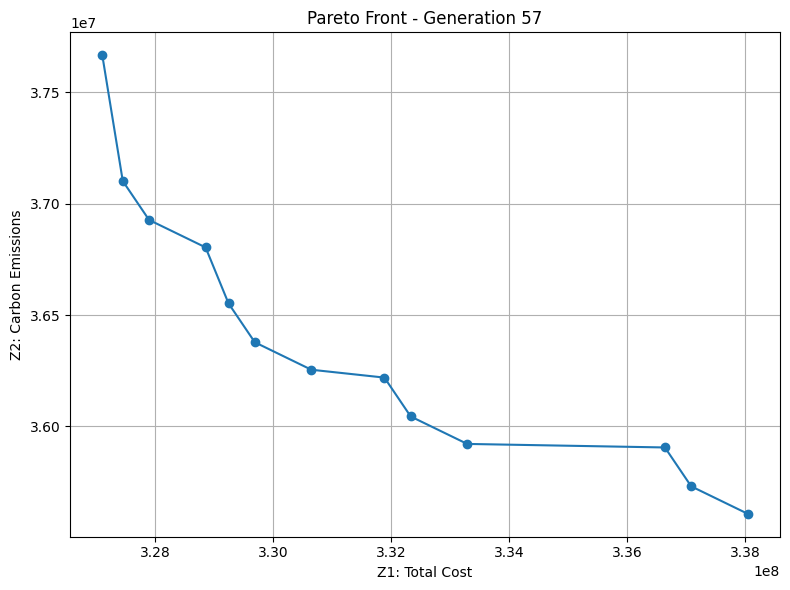

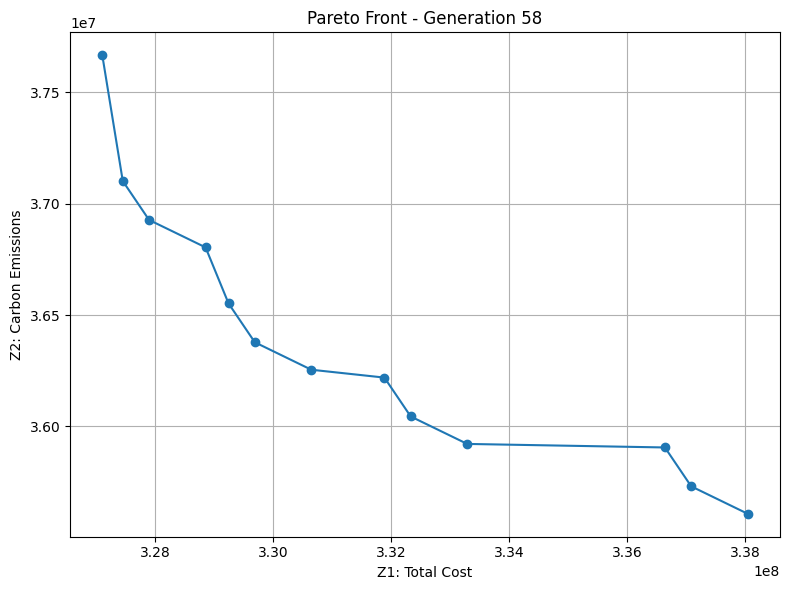

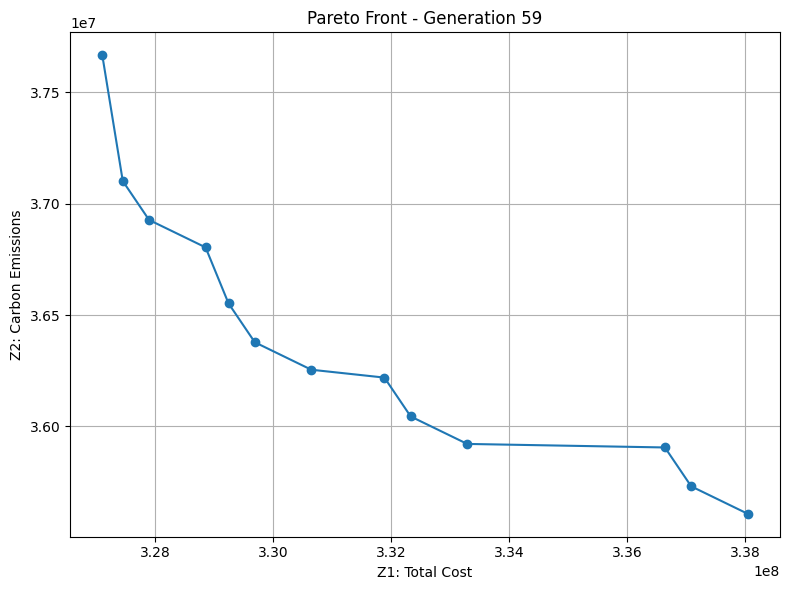

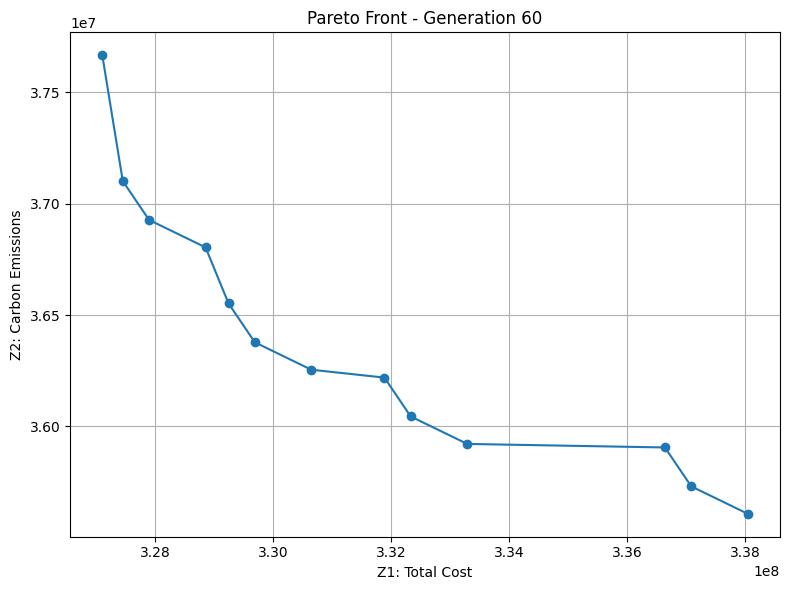

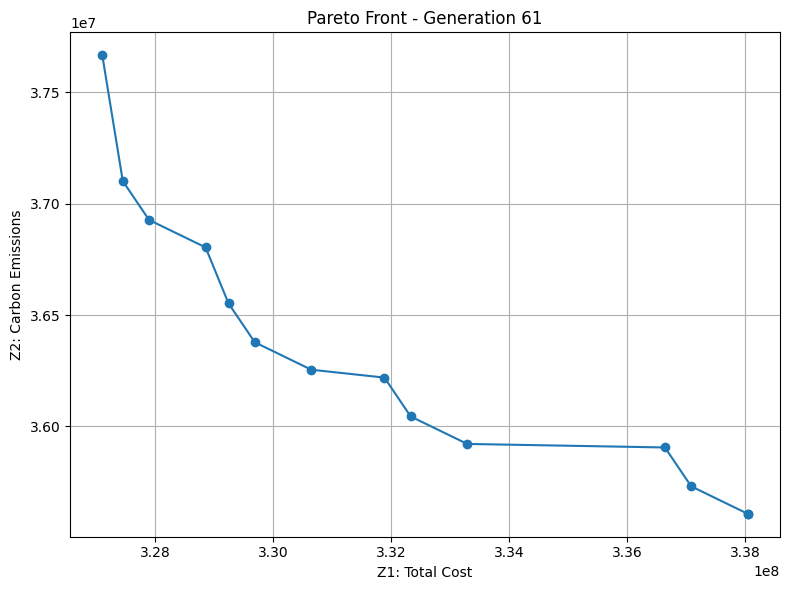

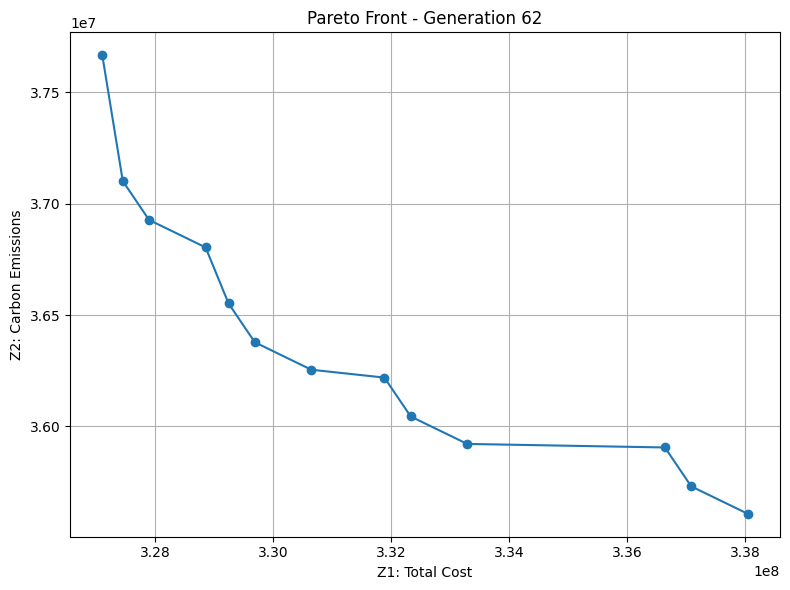

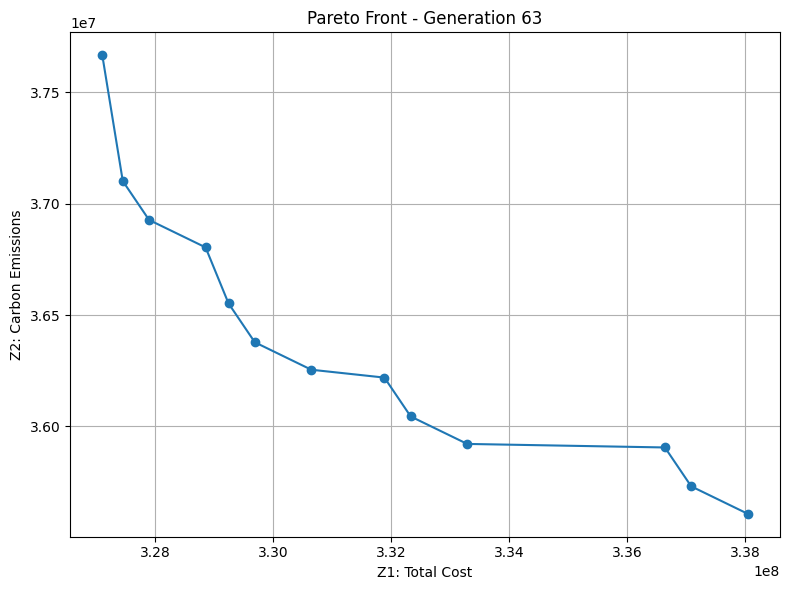

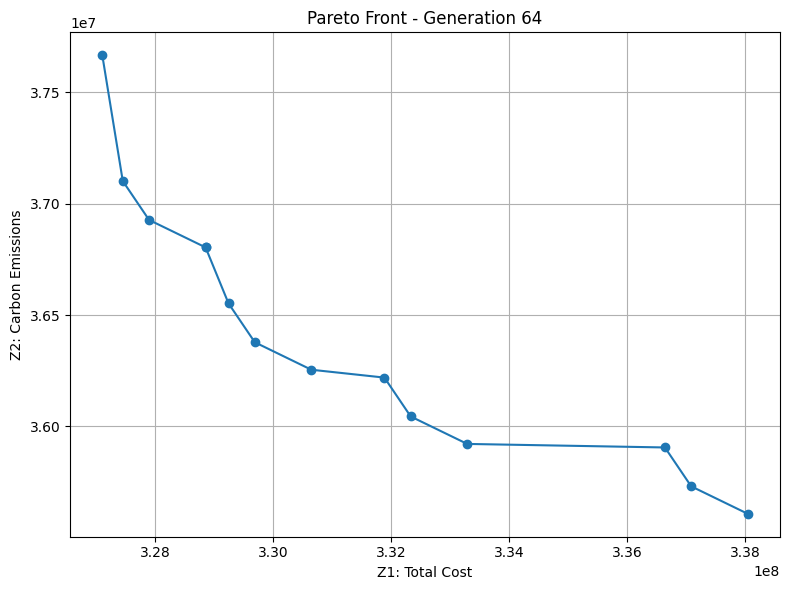

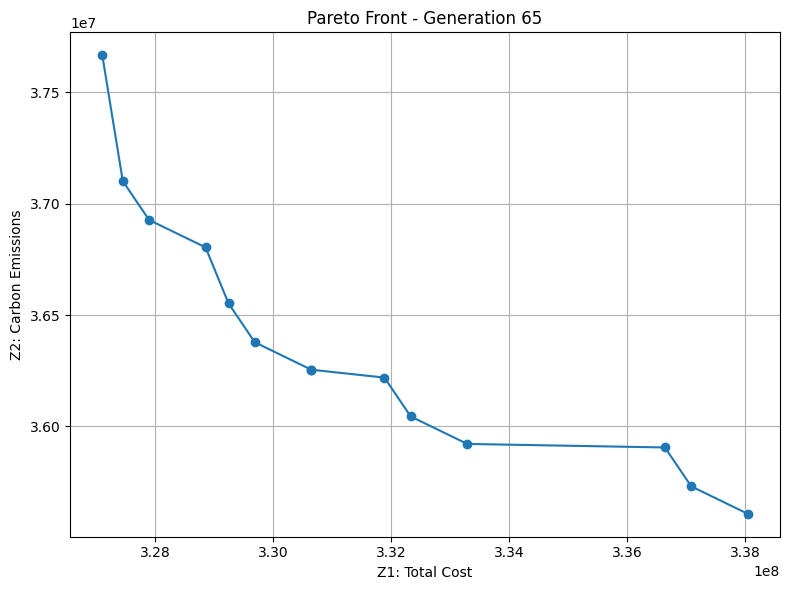

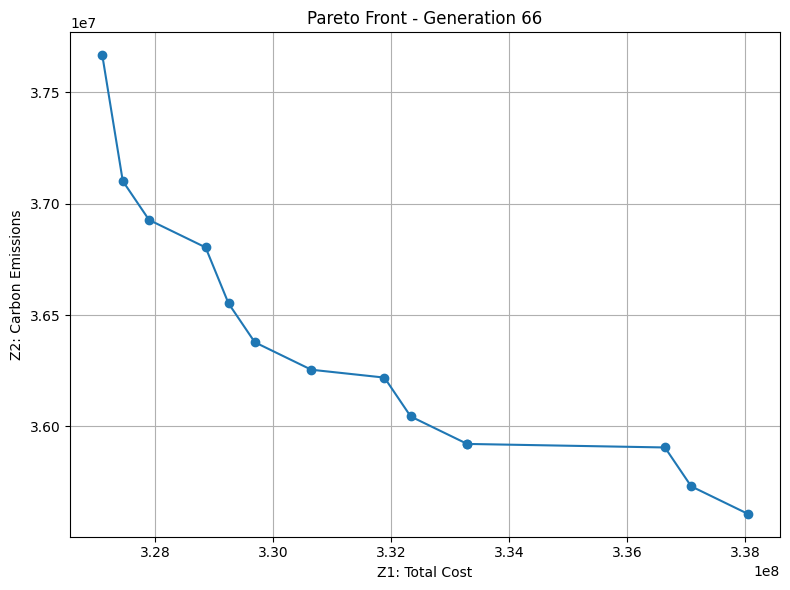

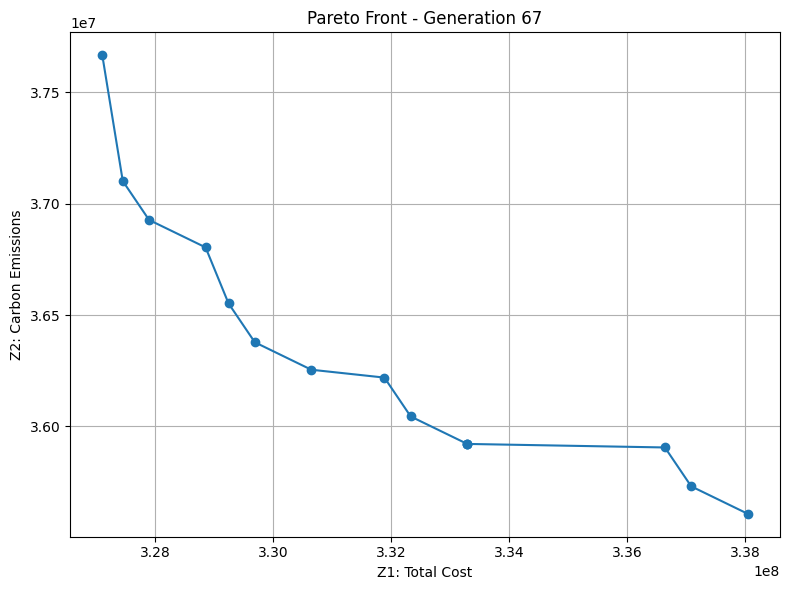

In [ ]:
plot_each_generation_separately(res)


In [ ]:
def plot_final_front_and_print_values(res):
    F = res.F
    Z1 = F[:, 0]
    Z2 = F[:, 1]
    sorted_idx = np.argsort(Z1)
    Z1_sorted = Z1[sorted_idx]
    Z2_sorted = Z2[sorted_idx]

    min_z1_idx = np.argmin(Z1)
    min_z2_idx = np.argmin(Z2)
    z1_best = (Z1[min_z1_idx], Z2[min_z1_idx])
    z2_best = (Z1[min_z2_idx], Z2[min_z2_idx])

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(Z1_sorted, Z2_sorted, '-o', color='darkgreen', label='Final Pareto Front')
    plt.scatter(*z1_best, color='blue', s=100, edgecolors='k', label=f'Min Z1\n({z1_best[0]:.2e}, {z1_best[1]:.2e})')
    plt.scatter(*z2_best, color='red', s=100, edgecolors='k', label=f'Min Z2\n({z2_best[0]:.2e}, {z2_best[1]:.2e})')
    plt.xlabel("Z1: Total Cost")
    plt.ylabel("Z2: Carbon Emissions")
    plt.title("Final Pareto Front (Last Generation)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("📋 Final Pareto Front [Z1, Z2] Values:")
    for i, (z1, z2) in enumerate(zip(Z1_sorted, Z2_sorted)):
        print(f"Solution {i+1:2}: Z1 = {z1:.2f}, Z2 = {z2:.2f}")


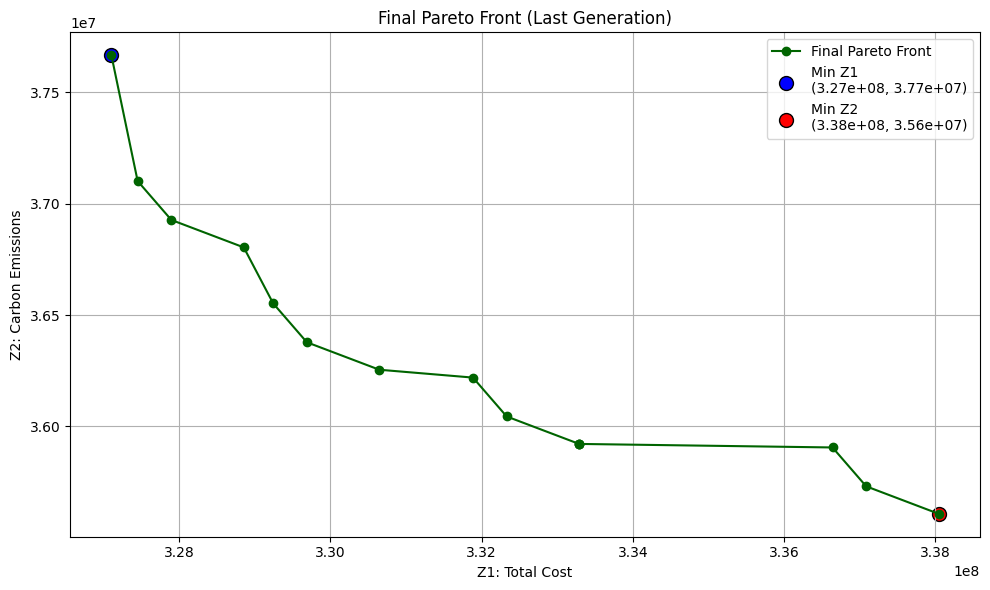

📋 Final Pareto Front [Z1, Z2] Values:
Solution  1: Z1 = 327102625.65, Z2 = 37667259.16
Solution  2: Z1 = 327449888.30, Z2 = 37102208.62
Solution  3: Z1 = 327895467.64, Z2 = 36927619.58
Solution  4: Z1 = 328853514.94, Z2 = 36804278.71
Solution  5: Z1 = 329242477.18, Z2 = 36552727.16
Solution  6: Z1 = 329688056.72, Z2 = 36378138.12
Solution  7: Z1 = 330646103.59, Z2 = 36254797.25
Solution  8: Z1 = 331885309.65, Z2 = 36219467.55
Solution  9: Z1 = 332330889.30, Z2 = 36044878.51
Solution 10: Z1 = 333288936.36, Z2 = 35921537.64
Solution 11: Z1 = 333288936.36, Z2 = 35921537.64
Solution 12: Z1 = 333288936.36, Z2 = 35921537.64
Solution 13: Z1 = 336640640.88, Z2 = 35905645.90
Solution 14: Z1 = 337086220.31, Z2 = 35731056.87
Solution 15: Z1 = 338044267.54, Z2 = 35607716.00


In [ ]:
plot_final_front_and_print_values(res)


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_all_generations_overlay(res):
    generations = len(res.history)
    cmap = cm.get_cmap("plasma", generations)
    norm = mcolors.Normalize(vmin=0, vmax=generations - 1)

    plt.figure(figsize=(10, 6))

    for gen_idx in range(generations):
        if gen_idx % 5 != 0 and gen_idx != generations - 1:
            continue

        F = res.history[gen_idx].opt.get("F")
        if F is None or len(F) < 2:
            continue

        Z1 = F[:, 0]
        Z2 = F[:, 1]
        sorted_idx = np.argsort(Z1)

        plt.plot(
            Z1[sorted_idx], Z2[sorted_idx],
            label=f"Gen {gen_idx}",
            color=cmap(norm(gen_idx)),
            linewidth=2 if gen_idx == generations - 1 else 1.5,
            alpha=1.0 if gen_idx == generations - 1 else 0.6
        )

    plt.xlabel("Z1: Total Cost")
    plt.ylabel("Z2: Carbon Emissions")
    plt.title("Pareto Front Evolution (Overlayed View)")
    plt.legend(fontsize=8, loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-29-306622822.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma", generations)


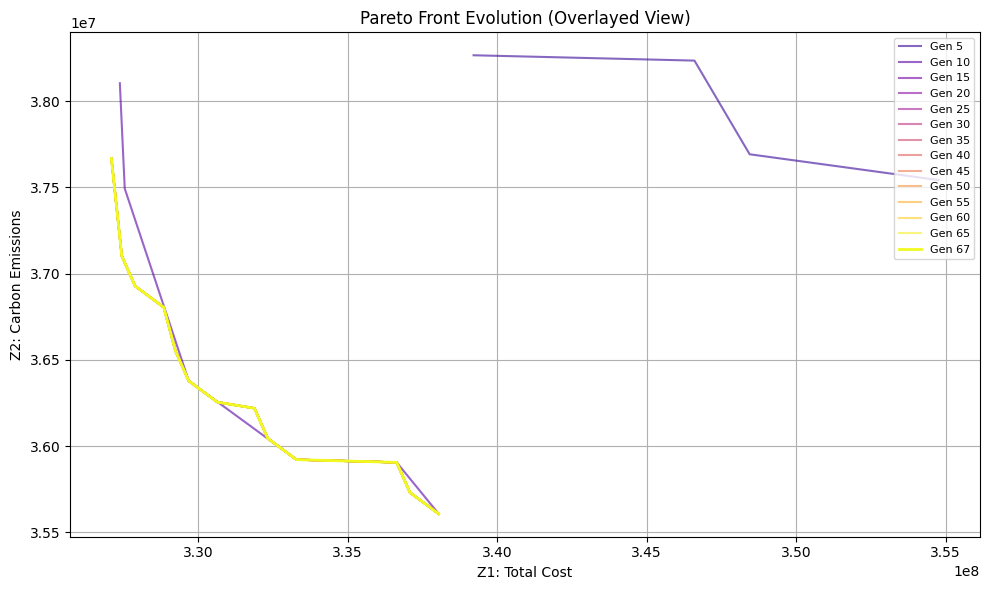

In [ ]:
plot_all_generations_overlay(res)


In [ ]:
def decode_assignments(x, params):
    n_customers = params["n_customers"]
    n_cdrc = params["n_cdrc"]
    n_products = params["n_products"]

    n_assign_vars = n_customers * n_products
    n_order_vars = n_cdrc * n_products

    assign_flat = x[:n_assign_vars]
    order_flat = x[n_assign_vars:]

    assign_flat = np.clip(np.floor(assign_flat), 0, n_cdrc - 1).astype(int)
    assignments = assign_flat.reshape((n_customers, n_products))
    order_qty = order_flat.reshape((n_cdrc, n_products))

    # Active CDRCs
    Y = np.zeros(n_cdrc, dtype=int)
    for i in range(n_customers):
        for p in range(n_products):
            Y[assignments[i, p]] = 1

    return assignments, order_qty, Y


In [ ]:
def print_decoded_solution(x, label=""):
    assignments, order_qty, Y = decode_assignments(x, params)
    print(f"\n📝 Decoded Assignments — {label}")

    print("\n🟦 Active CDRCs:")
    for r in range(len(Y)):
        if Y[r]:
            print(f"  - CDRC-{r+1}")

    print("\n🟩 Forward Assignments (Customer → CDRC):")
    for i in range(assignments.shape[0]):
        for p in range(assignments.shape[1]):
            r = assignments[i, p]
            print(f"  - Customer-{i+1}, Product-{p+1} → CDRC-{r+1}")

    print("\n📦 Order Quantities:")
    for r in range(order_qty.shape[0]):
        for p in range(order_qty.shape[1]):
            print(f"  - CDRC-{r+1}, Product-{p+1}: Q = {order_qty[r, p]:.2f}")


In [ ]:
# Best solution in final generation (lowest cost)
final_pop = res.pop.get("X")
final_F = res.pop.get("F")

best_idx = np.argmin(final_F[:, 0])  # minimum Z1
print_decoded_solution(final_pop[best_idx], label="Best Z1 in Final Gen")

# minimum z2
best_idx_z2 = np.argmin(final_F[:, 1])
print_decoded_solution(final_pop[best_idx_z2], label="Best Z2 in Final Gen")



📝 Decoded Assignments — Best Z1 in Final Gen

🟦 Active CDRCs:
  - CDRC-1
  - CDRC-2
  - CDRC-3

🟩 Forward Assignments (Customer → CDRC):
  - Customer-1, Product-1 → CDRC-2
  - Customer-1, Product-2 → CDRC-2
  - Customer-2, Product-1 → CDRC-1
  - Customer-2, Product-2 → CDRC-1
  - Customer-3, Product-1 → CDRC-1
  - Customer-3, Product-2 → CDRC-1
  - Customer-4, Product-1 → CDRC-2
  - Customer-4, Product-2 → CDRC-3
  - Customer-5, Product-1 → CDRC-3
  - Customer-5, Product-2 → CDRC-3
  - Customer-6, Product-1 → CDRC-2
  - Customer-6, Product-2 → CDRC-2
  - Customer-7, Product-1 → CDRC-1
  - Customer-7, Product-2 → CDRC-1
  - Customer-8, Product-1 → CDRC-2
  - Customer-8, Product-2 → CDRC-2
  - Customer-9, Product-1 → CDRC-2
  - Customer-9, Product-2 → CDRC-3
  - Customer-10, Product-1 → CDRC-2
  - Customer-10, Product-2 → CDRC-2

📦 Order Quantities:
  - CDRC-1, Product-1: Q = 10.04
  - CDRC-1, Product-2: Q = 10.32
  - CDRC-2, Product-1: Q = 10.00
  - CDRC-2, Product-2: Q = 10.04
  - CDR

In [ ]:
import pandas as pd

def export_pymoo_pareto_summary(res, elapsed_time):
    Z1_vals = res.F[:, 0]
    Z2_vals = res.F[:, 1]

    df = pd.DataFrame({
        "Z1 (Total Cost)": Z1_vals,
        "Z2 (Emissions)": Z2_vals,
        "Computation Time (s)": [elapsed_time] * len(Z1_vals)
    })

    df.index = [f"Solution {i+1}" for i in range(len(df))]
    print("📋 Pareto Front Summary Table (NSGA-II):")
    display(df)

    # Optionally save to file
    df.to_csv("nsga2_pareto_results.csv", index=True)
    print("\n✅ Exported to: nsga2_pareto_results.csv")

# Run this
export_pymoo_pareto_summary(res, elapsed_time)


📋 Pareto Front Summary Table (NSGA-II):


,Z1 (Total Cost),Z2 (Emissions),Computation Time (s)
Solution 1,3.332889e+08,3.592154e+07,4.247059
Solution 2,3.288535e+08,3.680428e+07,4.247059
Solution 3,3.323309e+08,3.604488e+07,4.247059
Solution 4,3.366406e+08,3.590565e+07,4.247059
Solution 5,3.306461e+08,3.625480e+07,4.247059
Solution 6,3.332889e+08,3.592154e+07,4.247059
Solution 7,3.278955e+08,3.692762e+07,4.247059
Solution 8,3.318853e+08,3.621947e+07,4.247059
Solution 9,3.292425e+08,3.655273e+07,4.247059
Solution 10,3.271026e+08,3.766726e+07,4.247059



✅ Exported to: nsga2_pareto_results.csv
